# Schedule TPC-DS 1 Feature Selection

This notebook is dedicated to dataset profiling. In this notebook, feature selection techniques will be implemented so as to categorize which features belay the most information to address the problem at hand - Workload Prediction. Due to the vast feature space which have been gathered during a workload's execution, manual techniques at determining which are most detrimental is not sufficient. 

Therefore the following work puts emphasis on automated techniques so as to determine out of the vast feature space which are most important to base future models upon. 

In [110]:
#
# Module Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, RFE
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from operator import itemgetter
from sklearn.metrics import r2_score

### Configuration Cell

Tweak parametric changes from this cell to influence outcome of experiment

In [111]:
tpcds='TPCDS1' # Schema upon which to operate test
debug_mode=True # Determines whether to plot graphs or not, useful for development purposes 
low_quartile_limit = 0 # Lower Quartile threshold to detect outliers
upper_quartile_limit = 1 # Upper Quartile threshold to detect outliers
test_split=.3 # Denotes which Data Split to operate under when it comes to training / validation

In [112]:
#
# Open Data
rep_hist_snapshot_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/rep_hist_snapshot.csv'
rep_hist_sysmetric_summary_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/rep_hist_sysmetric_summary.csv'
rep_hist_sysstat_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/rep_hist_sysstat.csv'
rep_vsql_plan_path = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds + '/rep_vsql_plan.csv'
#
rep_hist_snapshot_df = pd.read_csv(rep_hist_snapshot_path)
rep_hist_sysmetric_summary_df = pd.read_csv(rep_hist_sysmetric_summary_path)
rep_hist_sysstat_df = pd.read_csv(rep_hist_sysstat_path)
rep_vsql_plan_df = pd.read_csv(rep_vsql_plan_path)
#
def prettify_header(headers):
    """
    Cleans header list from unwated character strings
    """
    header_list = []
    [header_list.append(header.replace("(","").replace(")","").replace("'","").replace(",","")) for header in headers]
    return header_list
#
rep_hist_snapshot_df.columns = prettify_header(rep_hist_snapshot_df.columns.values)
rep_hist_sysmetric_summary_df.columns = prettify_header(rep_hist_sysmetric_summary_df.columns.values)
rep_hist_sysstat_df.columns = prettify_header(rep_hist_sysstat_df.columns.values)
rep_vsql_plan_df.columns = prettify_header(rep_vsql_plan_df.columns.values)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (6,20,21,22,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Dataset Description

The correlation of resources consumed (y) per snapshot (X) define our feature space. Since the objective here is to attempt to predict what resources will be incurred ahead of time, the problem can be defined as a number of questions:

* Q: What resources can I predict to be in usage at point N in time?
* Q: What resources should I be predicting that accurately portray a schedule's workload?
* Q: What knowledge/data do I have ahead of time which I can use to base my predictions off?

Due to the vast feature space in the available metrics monitored and captured during a workload's execution, it is important to rank which attribute is most beneficial than others. Additionally, it is important to analyze such features individually, and considerate of other features in two types of analysis:

* Univariate Analysis
* Multivariate Analysis

Furthermore, multiple types of feature ranking / analysis techniques ara available, amongst which will be considered:

* Filter Methods
* Wrapper Methods
* Embedded Methods

# Data Preprocessing

We apply a number of preprocessing techniques to the presented dataframes, particularly to normalize and/or scale feature vectors into a more suitable representation for downstream estimators:

Relative Links:
* http://scikit-learn.org/stable/modules/preprocessing.html
* https://machinelearningmastery.com/improve-model-accuracy-with-data-pre-processing/
* https://machinelearningmastery.com/normalize-standardize-time-series-data-python/

### Table Pivots

To better handle the following table, a number of table pivots are made on tables:
* rep_hist_sysmetric_summary
* rep_hist_sysstat

In [113]:
#
# Table REP_HIST_SYSMETRIC_SUMMARY
rep_hist_sysmetric_summary_df = rep_hist_sysmetric_summary_df.pivot(index='SNAP_ID', columns='METRIC_NAME', values='AVERAGE')
rep_hist_sysmetric_summary_df.reset_index(inplace=True)
print(rep_hist_sysmetric_summary_df.columns)
rep_hist_sysmetric_summary_df[['SNAP_ID']] = rep_hist_sysmetric_summary_df[['SNAP_ID']].astype(int)
rep_hist_sysmetric_summary_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)
print("REP_HIST_SYSMETRIC Shape: " + str(rep_hist_sysmetric_summary_df.shape))
#
# Table REP_HIST_SYSSTAT
rep_hist_sysstat_df = rep_hist_sysstat_df.pivot(index='SNAP_ID', columns='STAT_NAME', values='VALUE')
rep_hist_sysstat_df.reset_index(inplace=True)
print(rep_hist_sysstat_df.columns)
rep_hist_sysstat_df[['SNAP_ID']] = rep_hist_sysstat_df[['SNAP_ID']].astype(int)
rep_hist_sysstat_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)
print("REP_HIST_SYSSTAT_DF Shape: " + str(rep_hist_sysstat_df.shape))
#
# Refreshing columns with pivoted columns
def convert_list_to_upper(col_list):
    """
    Takes a string and converts elements to upper
    """
    upper_col_list = []
    for col in col_list:
        upper_col_list.append(col.upper())
    return upper_col_list
#
rep_hist_sysmetric_summary_df.rename(str.upper, inplace=True, axis='columns')
rep_hist_sysstat_df.rename(str.upper, inplace=True, axis='columns')
#
rep_hist_snapshot_headers = rep_hist_snapshot_df.columns
rep_hist_sysmetric_summary_headers = list(rep_hist_sysmetric_summary_df.columns)
rep_hist_sysstat_headers = list(rep_hist_sysstat_df.columns)
rep_vsql_plan_headers = rep_vsql_plan_df.columns
#
# DF Shape
print('\n\nTable [REP_HIST_SNAPSHOT] - ' + str(rep_hist_snapshot_df.shape))
print('Table [REP_HIST_SYSMETRIC_SUMMARY] - ' + str(rep_hist_sysmetric_summary_df.shape))
print('Table [REP_HIST_SYSSTAT] - ' + str(rep_hist_sysstat_df.shape))
print('Table [REP_VSQL_PLAN] - ' + str(rep_vsql_plan_df.shape))

Index(['SNAP_ID', 'Active Parallel Sessions', 'Active Serial Sessions',
       'Average Active Sessions',
       'Average Synchronous Single-Block Read Latency',
       'Background CPU Usage Per Sec', 'Background Checkpoints Per Sec',
       'Background Time Per Sec', 'Branch Node Splits Per Sec',
       'Branch Node Splits Per Txn',
       ...
       'User Commits Percentage', 'User Limit %',
       'User Rollback Undo Records Applied Per Txn',
       'User Rollback UndoRec Applied Per Sec', 'User Rollbacks Per Sec',
       'User Rollbacks Percentage', 'User Transaction Per Sec',
       'VM in bytes Per Sec', 'VM out bytes Per Sec',
       'Workload Capture and Replay status'],
      dtype='object', name='METRIC_NAME', length=162)
REP_HIST_SYSMETRIC Shape: (4018, 162)
Index(['SNAP_ID', 'ADG global flush', 'ADG parselock X get attempts',
       'ADG parselock X get successes', 'BA au bytes allocated',
       'BA bytes for file maps', 'BA bytes read from disk',
       'BA bytes read fro

### Checking for NaN Values

Checking dataframes for potential missing values/data:

In [114]:
def get_na_columns(df, headers):
    """
    Return columns which consist of NAN values
    """
    na_list = []
    for head in headers:
        if df[head].isnull().values.any():
            na_list.append(head)
    return na_list
#
print("Table REP_HIST_SNAPSHOT: " + str(get_na_columns(df=rep_hist_snapshot_df,headers=rep_hist_snapshot_headers)) + "\n\n")
print("Table REP_HIST_SYSMETRIC_SUMMARY: " + str(get_na_columns(df=rep_hist_sysmetric_summary_df,headers=rep_hist_sysmetric_summary_headers)) + "\n\n")
print("Table REP_HIST_SYSSTAT: " + str(get_na_columns(df=rep_hist_sysstat_df,headers=rep_hist_sysstat_headers)) + "\n\n")
print("Table REP_VSQL_PLAN: " + str(get_na_columns(df=rep_vsql_plan_df,headers=rep_vsql_plan_headers)) + "\n\n")
#
def fill_na(df):
    """
    Replaces NA columns with 0s
    """
    return df.fillna(0)
#
# Populating NaN values with amount '0'
rep_hist_snapshot_df = fill_na(df=rep_hist_snapshot_df)
rep_hist_sysmetric_summary_df = fill_na(df=rep_hist_sysmetric_summary_df)
rep_hist_sysstat_df = fill_na(df=rep_hist_sysstat_df)
rep_vsql_plan_df = fill_na(df=rep_vsql_plan_df)

Table REP_HIST_SNAPSHOT: ['OPTIMIZER_COST', 'OPTIMIZER_MODE', 'OPTIMIZER_ENV_HASH_VALUE', 'LOADED_VERSIONS', 'MODULE', 'ACTION', 'SQL_PROFILE', 'PARSING_SCHEMA_ID', 'PARSING_SCHEMA_NAME', 'PARSING_USER_ID', 'FETCHES_TOTAL', 'FETCHES_DELTA', 'END_OF_FETCH_COUNT_TOTAL', 'END_OF_FETCH_COUNT_DELTA', 'SORTS_TOTAL', 'SORTS_DELTA', 'EXECUTIONS_TOTAL', 'EXECUTIONS_DELTA', 'PX_SERVERS_EXECS_TOTAL', 'PX_SERVERS_EXECS_DELTA', 'LOADS_TOTAL', 'LOADS_DELTA', 'INVALIDATIONS_TOTAL', 'INVALIDATIONS_DELTA', 'PARSE_CALLS_TOTAL', 'DISK_READS_TOTAL', 'DISK_READS_DELTA', 'BUFFER_GETS_TOTAL', 'BUFFER_GETS_DELTA', 'ROWS_PROCESSED_TOTAL', 'ROWS_PROCESSED_DELTA', 'CPU_TIME_TOTAL', 'ELAPSED_TIME_TOTAL', 'IOWAIT_TOTAL', 'IOWAIT_DELTA', 'CLWAIT_TOTAL', 'CLWAIT_DELTA', 'APWAIT_TOTAL', 'APWAIT_DELTA', 'CCWAIT_TOTAL', 'CCWAIT_DELTA', 'DIRECT_WRITES_TOTAL', 'DIRECT_WRITES_DELTA', 'PLSEXEC_TIME_TOTAL', 'PLSEXEC_TIME_DELTA', 'JAVEXEC_TIME_TOTAL', 'JAVEXEC_TIME_DELTA', 'IO_OFFLOAD_ELIG_BYTES_TOTAL', 'IO_OFFLOAD_ELIG_BYTE

### Checking for Negative Values

A function which retrieves a count per column for nay negative values it might contain

In [115]:
def count_neg_df(df, headers):
    """
    Return columns with respective negative value count
    """
    neg_list = []
    for head in headers:
        count = 0
        try:
            count = sum(n < 0 for n in df[head].values.flatten())
        except Exception:
            pass
            #print('Non numeric column [' + head + ']')
        if count > 0:
            neg_list.append([head,count])
    return neg_list
#
def fill_neg(df, headers):
    """
    Sets any data anomilies resulting in negative values to 0
    
    :param headers: list as follows eg: ['column_name', 'negative_count']
    """
    for head in headers:
        try:
            df[df[head[0]] < 0] = 0
        except Exception:
            pass
            #print('Non numeric column [' + head + ']')
    return df
#
# Check For Negative Values within dataframes
print('---------------WITH NEGATIVE VALUES---------------')
print("Table REP_HIST_SNAPSHOT: " + str(count_neg_df(df=rep_hist_snapshot_df,headers=rep_hist_snapshot_headers)) + "\n\n")
print("Table REP_HIST_SYSMETRIC_SUMMARY: " + str(count_neg_df(df=rep_hist_sysmetric_summary_df,headers=rep_hist_sysmetric_summary_headers)) + "\n\n")
print("Table REP_HIST_SYSSTAT: " + str(count_neg_df(df=rep_hist_sysstat_df,headers=rep_hist_sysstat_headers)) + "\n\n")
print("Table REP_VSQL_PLAN: " + str(count_neg_df(df=rep_vsql_plan_df,headers=rep_vsql_plan_headers)) + "\n\n")
#
# Replace Negative Values with a minimal threshold of 0
rep_hist_snapshot_df = fill_neg(df=rep_hist_snapshot_df,headers=count_neg_df(df=rep_hist_snapshot_df,headers=rep_hist_snapshot_headers))
rep_hist_sysmetric_summary_df = fill_neg(df=rep_hist_sysmetric_summary_df,headers=count_neg_df(df=rep_hist_sysmetric_summary_df,headers=rep_hist_sysmetric_summary_headers))
rep_hist_sysstat_df = fill_neg(df=rep_hist_sysstat_df,headers=count_neg_df(df=rep_hist_sysstat_df,headers=rep_hist_sysstat_headers))
rep_vsql_plan_df = fill_neg(df=rep_vsql_plan_df,headers=count_neg_df(df=rep_vsql_plan_df,headers=rep_vsql_plan_headers))
#
# Check For Negative Values within dataframes
print('\n\n---------------WITHOUT NEGATIVE VALUES---------------')
print("Table REP_HIST_SNAPSHOT: " + str(count_neg_df(df=rep_hist_snapshot_df,headers=rep_hist_snapshot_headers)) + "\n\n")
print("Table REP_HIST_SYSMETRIC_SUMMARY: " + str(count_neg_df(df=rep_hist_sysmetric_summary_df,headers=rep_hist_sysmetric_summary_headers)) + "\n\n")
print("Table REP_HIST_SYSSTAT: " + str(count_neg_df(df=rep_hist_sysstat_df,headers=rep_hist_sysstat_headers)) + "\n\n")
print("Table REP_VSQL_PLAN: " + str(count_neg_df(df=rep_vsql_plan_df,headers=rep_vsql_plan_headers)) + "\n\n")

---------------WITH NEGATIVE VALUES---------------
Table REP_HIST_SNAPSHOT: [['IO_OFFLOAD_RETURN_BYTES_TOTAL', 6153], ['IO_OFFLOAD_RETURN_BYTES_DELTA', 162]]


Table REP_HIST_SYSMETRIC_SUMMARY: []


Table REP_HIST_SYSSTAT: []


Table REP_VSQL_PLAN: []




---------------WITHOUT NEGATIVE VALUES---------------
Table REP_HIST_SNAPSHOT: []


Table REP_HIST_SYSMETRIC_SUMMARY: []


Table REP_HIST_SYSSTAT: []


Table REP_VSQL_PLAN: []




### Feature Selection

In this step, redundant features are dropped. Features are considered redundant if exhibit a standard devaition of 0 (meaning no change in value).

In [116]:
def drop_flatline_columns(df):
    columns = df.columns
    flatline_features = []
    for i in range(len(columns)):
        try:
            std = df[columns[i]].std()
            if std == 0:
                flatline_features.append(columns[i])
        except:
            pass
    #
    #print('Features which are considered flatline:\n')
    #for col in flatline_features:
    #    print(col)
    print('\nShape before changes: [' + str(df.shape) + ']')
    df = df.drop(columns=flatline_features)
    print('Shape after changes: [' + str(df.shape) + ']')
    print('Dropped a total [' + str(len(flatline_features)) + ']')
    return df
#
rep_hist_snapshot_df = drop_flatline_columns(df=rep_hist_snapshot_df)
rep_hist_sysmetric_summary_df = drop_flatline_columns(df=rep_hist_sysmetric_summary_df)
rep_hist_sysstat_df = drop_flatline_columns(df=rep_hist_sysstat_df)
rep_vsql_plan_df = drop_flatline_columns(df=rep_vsql_plan_df)
#
rep_hist_snapshot_headers = rep_hist_snapshot_df.columns
rep_hist_sysmetric_summary_headers = rep_hist_sysmetric_summary_df.columns
rep_hist_sysstat_headers = rep_hist_sysstat_df.columns
rep_vsql_plan_headers = rep_vsql_plan_df.columns


Shape before changes: [(329200, 90)]
Shape after changes: [(329200, 77)]
Dropped a total [13]

Shape before changes: [(4018, 162)]
Shape after changes: [(4018, 140)]
Dropped a total [22]

Shape before changes: [(4019, 1179)]
Shape after changes: [(4019, 321)]
Dropped a total [858]

Shape before changes: [(61384, 39)]
Shape after changes: [(61384, 31)]
Dropped a total [8]


## Visualizing Feature Distribution & Skewness

In order to decide between a normalization strategy, it is important to understand the underlying data spread. Understanding of dataset mean, variance, skewness on a per column/feature basis helps determine whether a standardization or normalization strategy should be utilized on the datasets.

### Plotting Data Distribution

To better decide which normalization technique ought to be utilized for the technique at hand, a number of feature columns will be plotted as histograms to better convey the distribution spread.

In [117]:
def plot_hist(df=None, tpc_type=None, table=None, feature_column=None, bin_size=10):
    """
    Plots histogram distribution
    """
    #
    try:
        df['SNAP_ID'] = df['SNAP_ID'].astype(float)
        df[feature_column] = df[feature_column].astype(float)
        #
        max_val = df[feature_column].max()
        start_snap, end_snap = int(df['SNAP_ID'].min()), int(df['SNAP_ID'].max())
        #
        df[feature_column].hist(bins=10,figsize=(12,8))
        plt.ylabel(feature_column)
        plt.xlabel('Bin Ranges Of ' + str(int(max_val/bin_size)))
        plt.title(tpc_type + ' Table ' + table.upper() + '.' + str(feature_column) + " between " + str(start_snap) + " - " + str(end_snap))
        plt.show()
    except Exception:
        print('Could not plot column: ' + feature_column)
#
def plot_scatter(df=None, tpc_type=None, table=None, feature_column=None):
    """
    Plots scatter plots vs SNAP_ID
    """
    #
    try:
        df['SNAP_ID'] = df['SNAP_ID'].astype(int)
        df[feature_column] = df[feature_column].astype(int)
        start_snap, end_snap = int(df['SNAP_ID'].min()), int(df['SNAP_ID'].max())
        #
        df.plot.scatter(x='SNAP_ID',
                        y=feature_column,
                        figsize=(12,8))
        plt.ylabel(feature_column)
        plt.xlabel('SNAP ID')
        plt.title(tpc_type + ' Table ' + table.upper() + '.' + str(feature_column) + " between " + str(start_snap) + " - " + str(end_snap))
        plt.show()
    except Exception:
        print('Could not plot column: ' + feature_column)
#
def plot_boxplot(df=None, tpc_type=None, table=None, feature_columns=None):
    """
    Plots quartile plots to estimate mean and sigma (std dev)
    """
    #
    try:
        for feature_column in feature_columns:
            df[feature_column] = df[feature_column].astype(int)
        df.boxplot(column=feature_columns, figsize=(12,8), grid=True)
        plt.title(tpc_type + ' ' + str(feature_columns))
        plt.show()
    except Exception:
        print('Could not plot column: ' + feature_column)
#
if debug_mode is False:
    #
    # Plotting Histograms of data distribution
    for header in rep_hist_snapshot_headers:
        print('REP_HIST_SNAPSHOT - ' + header + ' - OUTLIERS HISTOGRAM')
        plot_hist(df=rep_hist_snapshot_df, tpc_type=tpcds, table='rep_hist_snapshot', feature_column=header, bin_size=10)
    for header in rep_hist_sysmetric_summary_headers:
        print('REP_HIST_SYSMETRIC_SUMMARY - ' + header + ' - OUTLIERS HISTOGRAM')
        plot_hist(df=rep_hist_sysmetric_summary_df, tpc_type=tpcds, table='rep_hist_sysmetric_summary', feature_column=header, bin_size=10)
    for header in rep_hist_sysstat_headers:
        print('REP_HIST_SYSSTAT - ' + header + ' - OUTLIERS HISTOGRAM')
        plot_hist(df=rep_hist_sysstat_df, tpc_type=tpcds, table='rep_hist_sysstat', feature_column=header, bin_size=10)
    #
    # Plotting Scatter Plots of data distribution
    for header in rep_hist_snapshot_headers:
        print('REP_HIST_SNAPSHOT - ' + header + ' - OUTLIERS SCATTER')
        plot_scatter(df=rep_hist_snapshot_df, tpc_type=tpcds,table='rep_hist_snapshot',feature_column=header)
    for header in rep_hist_sysmetric_summary_headers:
        print('REP_HIST_SYSMETRIC_SUMMARY - ' + header + ' - OUTLIERS SCATTER')
        plot_scatter(df=rep_hist_sysmetric_summary_df, tpc_type=tpcds,table='rep_hist_sysmetric_summary',feature_column=header)
    for header in rep_hist_sysstat_headers:
        print('REP_HIST_SYSSTAT - ' + header + ' - OUTLIERS SCATTER')
        plot_scatter(df=rep_hist_sysstat_df, tpc_type=tpcds,table='rep_hist_sysstat',feature_column=header)
    #
    # Plotting Box Plots of data distribution
    whisker_boxes_per_plot = 3
    for i in range(whisker_boxes_per_plot, len(rep_hist_snapshot_headers), whisker_boxes_per_plot):
        print('REP_HIST_SNAPSHOT - ' + header + ' - OUTLIERS WHISKER')
        plot_boxplot(df=rep_hist_snapshot_df, tpc_type=tpcds,table='rep_hist_snapshot',feature_columns=rep_hist_snapshot_headers[i-whisker_boxes_per_plot:i])

### Outlier Handling

https://machinelearningmastery.com/how-to-identify-outliers-in-your-data/

As can be appreciated from the previous plots, data is heavily skewed on particular (smallest) bins. This skew in the plotted histograms is a result of data point outliers - these need to be evaluated and removed if neccessary.

Following the 3 Standard Deviation Rule, we can categorize our dataset into subsets consisting of the following ranges:
* 0     - 68.27%
* 68.28 - 95.45%
* 95.46 - 99.73%
* 99.74 - 100%

It should be mentioned, that given the time series nature of the dataset, it is not a safe assumption to ignore outliers. By training respective models on outlier insensitive dataset, we would invite a potential problem, which risks blinding any models we train to future predicted spikes of activity.

In [118]:
def get_outliers(df=None, low_quartile_limit=.01, upper_quartile_limit=.99, headers=None):
    """
    Detect and return which rows are considered outliers within the dataset, determined by :quartile_limit (99%)
    """
    outlier_rows = [] # This list of lists consists of elements of the following notation [column,rowid]
    for header in headers:
        try:
            df[header] = df[header].astype(float)
            q = df[header].quantile(upper_quartile_limit)
            series_row = (df[df[header] > q].index)
            for id in list(np.array(series_row)):
                outlier_rows.append([header,id])
            q = df[header].quantile(low_quartile_limit)
            series_row = (df[df[header] < q].index)
            for id in list(np.array(series_row)):
                outlier_rows.append([header,id])
        except Exception as e:
            print(str(e))
    #
    unique_ids = []
    unique_outlier_rows = []
    #
    for col, rowid in outlier_rows:
        if rowid not in unique_ids:
            unique_outlier_rows.append([col,rowid])
            unique_ids.append(rowid)
    return unique_outlier_rows
#
def remove_outliers(df=None, low_quartile_limit=.01, upper_quartile_limit=.99, headers=None):
    """
    Remove rows which are considered outliers within the dataset, determined by :quartile_limit (99%)
    """
    length_before = len(df)
    outliers_index = []
    for header in headers:
        try:
            df[header] = df[header].astype(float)
            q = df[header].quantile(upper_quartile_limit)
            outliers_index.append(list(np.array(df[df[header] > q].index)))
            q = df[header].quantile(low_quartile_limit)
            outliers_index.append(list(np.array(df[df[header] < q].index)))
        except Exception as e:
            print(str(e))
    #flat_outliers_index = [item for sublist in l for item in outliers_index]
    flat_outliers_index = [item for sublist in outliers_index for item in sublist]
    outliers_index = list(set(flat_outliers_index))
    df = df.drop(outliers_index)
    return df
#
# Defining which columns will be exposed to outliers
# rep_hist_snapshot_header_outliers = rep_hist_snapshot_headers
rep_hist_snapshot_header_outliers = ['PLAN_HASH_VALUE',
                                    'OPTIMIZER_COST',
                                    'OPTIMIZER_ENV_HASH_VALUE',
                                    'SHARABLE_MEM',
                                    'LOADED_VERSIONS',
                                    'VERSION_COUNT',
                                    'FORCE_MATCHING_SIGNATURE',
                                    'PARSING_SCHEMA_ID',
                                    'PARSING_USER_ID',
                                    'FETCHES_TOTAL',
                                    'FETCHES_DELTA',
                                    'END_OF_FETCH_COUNT_TOTAL',
                                    'END_OF_FETCH_COUNT_DELTA',
                                    'SORTS_TOTAL',
                                    'SORTS_DELTA',
                                    'EXECUTIONS_TOTAL',
                                    'EXECUTIONS_DELTA',
                                    'PX_SERVERS_EXECS_TOTAL',
                                    'PX_SERVERS_EXECS_DELTA',
                                    'LOADS_TOTAL',
                                    'LOADS_DELTA',
                                    'INVALIDATIONS_TOTAL',
                                    'INVALIDATIONS_DELTA',
                                    'PARSE_CALLS_TOTAL',
                                    'PARSE_CALLS_DELTA',
                                    'DISK_READS_TOTAL',
                                    'DISK_READS_DELTA',
                                    'BUFFER_GETS_TOTAL',
                                    'BUFFER_GETS_DELTA',
                                    'ROWS_PROCESSED_TOTAL',
                                    'ROWS_PROCESSED_DELTA',
                                    'CPU_TIME_TOTAL',
                                    'CPU_TIME_DELTA',
                                    'ELAPSED_TIME_TOTAL',
                                    'ELAPSED_TIME_DELTA',
                                    'IOWAIT_TOTAL',
                                    'IOWAIT_DELTA',
                                    'CLWAIT_TOTAL',
                                    'CLWAIT_DELTA',
                                    'APWAIT_TOTAL',
                                    'APWAIT_DELTA',
                                    'CCWAIT_TOTAL',
                                    'CCWAIT_DELTA',
                                    'DIRECT_WRITES_TOTAL',
                                    'DIRECT_WRITES_DELTA',
                                    'PLSEXEC_TIME_TOTAL',
                                    'PLSEXEC_TIME_DELTA',
                                    'JAVEXEC_TIME_TOTAL',
                                    'JAVEXEC_TIME_DELTA',
                                    'IO_OFFLOAD_ELIG_BYTES_TOTAL',
                                    'IO_OFFLOAD_ELIG_BYTES_DELTA',
                                    'IO_INTERCONNECT_BYTES_TOTAL',
                                    'IO_INTERCONNECT_BYTES_DELTA',
                                    'PHYSICAL_READ_REQUESTS_TOTAL',
                                    'PHYSICAL_READ_REQUESTS_DELTA',
                                    'PHYSICAL_READ_BYTES_TOTAL',
                                    'PHYSICAL_READ_BYTES_DELTA',
                                    'PHYSICAL_WRITE_REQUESTS_TOTAL',
                                    'PHYSICAL_WRITE_REQUESTS_DELTA',
                                    'PHYSICAL_WRITE_BYTES_TOTAL',
                                    'PHYSICAL_WRITE_BYTES_DELTA',
                                    'OPTIMIZED_PHYSICAL_READS_TOTAL',
                                    'OPTIMIZED_PHYSICAL_READS_DELTA',
                                    'CELL_UNCOMPRESSED_BYTES_TOTAL',
                                    'CELL_UNCOMPRESSED_BYTES_DELTA',
                                    'IO_OFFLOAD_RETURN_BYTES_TOTAL',
                                    'IO_OFFLOAD_RETURN_BYTES_DELTA']
rep_hist_sysmetric_summary_header_outliers = rep_hist_sysmetric_summary_headers
rep_hist_sysstat_header_outliers = rep_hist_sysstat_headers
#rep_vsql_plan_headers_outliers = rep_vsql_plan_headers
rep_vsql_plan_headers_outliers = ['PLAN_HASH_VALUE',
                                  'FULL_PLAN_HASH_VALUE',
                                  'CHILD_NUMBER',
                                  'PARENT_ID',
                                  'DEPTH',
                                  'POSITION',
                                  'SEARCH_COLUMNS',
                                  'COST',
                                  'CARDINALITY',
                                  'BYTES',
                                  'PARTITION_ID',
                                  'IO_COST',
                                  'TEMP_SPACE',
                                  'TIME',
                                  'CON_ID']
#
#Printing outliers to screen
outliers = get_outliers(df=rep_hist_snapshot_df,
                           headers=rep_hist_snapshot_header_outliers,
                           upper_quartile_limit=upper_quartile_limit,
                           low_quartile_limit=low_quartile_limit)
for header, loc in outliers:
    print(str(loc+2) + " - " + str(rep_hist_snapshot_df.iloc[loc]['SQL_ID']) + " - " + str(header) + " - " + str(rep_hist_snapshot_df.iloc[loc][header]))
#
# Printing dataframe before adjustments
print('\n\nDATAFRAMES WITH OUTLIERS')
print(rep_hist_snapshot_df.shape)
print(rep_hist_sysmetric_summary_df.shape)
print(rep_hist_sysstat_df.shape)
print(rep_vsql_plan_df.shape)
print('----------------------------')
#
#Printing outliers to screen
rep_hist_snapshot_df_outliers = get_outliers(df=rep_hist_snapshot_df, 
                                             headers=rep_hist_snapshot_header_outliers,
                                             upper_quartile_limit=upper_quartile_limit,
                                             low_quartile_limit=low_quartile_limit)
rep_hist_sysmetric_summary_df_outliers = get_outliers(df=rep_hist_sysmetric_summary_df, headers=rep_hist_sysmetric_summary_header_outliers,upper_quartile_limit=upper_quartile_limit,low_quartile_limit=low_quartile_limit)
rep_hist_sysstat_df_outliers = get_outliers(df=rep_hist_sysstat_df, headers=rep_hist_sysstat_header_outliers,upper_quartile_limit= upper_quartile_limit,low_quartile_limit=low_quartile_limit)
rep_vsql_plan_df_outliers = get_outliers(df=rep_vsql_plan_df, headers=rep_vsql_plan_headers_outliers,upper_quartile_limit=upper_quartile_limit,low_quartile_limit=low_quartile_limit)
print('\n\nOUTLIERS')
print(len(rep_hist_snapshot_df_outliers))
print(len(rep_hist_sysmetric_summary_df_outliers))
print(len(rep_hist_sysstat_df_outliers))
print(len(rep_vsql_plan_df_outliers))
print('----------------------------')
#
# Dropping Outliers
rep_hist_snapshot_df_pruned = remove_outliers(df=rep_hist_snapshot_df, headers=rep_hist_snapshot_header_outliers,upper_quartile_limit=upper_quartile_limit,low_quartile_limit=low_quartile_limit)
rep_hist_sysmetric_summary_df_pruned = remove_outliers(df=rep_hist_sysmetric_summary_df, headers=rep_hist_sysmetric_summary_header_outliers,upper_quartile_limit=upper_quartile_limit,low_quartile_limit=low_quartile_limit)
rep_hist_sysstat_df_pruned = remove_outliers(df=rep_hist_sysstat_df, headers=rep_hist_sysstat_header_outliers,upper_quartile_limit=upper_quartile_limit,low_quartile_limit=low_quartile_limit)
rep_vsql_plan_df_pruned = remove_outliers(df=rep_vsql_plan_df, headers=rep_vsql_plan_headers_outliers,upper_quartile_limit=upper_quartile_limit,low_quartile_limit=low_quartile_limit)
print('\n\nDATAFRAMES WITHOUT OUTLIERS')
print(rep_hist_snapshot_df_pruned.shape)
print(rep_hist_sysmetric_summary_df_pruned.shape)
print(rep_hist_sysstat_df_pruned.shape)
print(rep_vsql_plan_df_pruned.shape)
#
print('\n\nFirst 20 record sample before outliers:')
print(rep_hist_snapshot_df.iloc[0:20]['SQL_ID'])
print('---------------------------------------')
print('First 20 record sample after outliers:')
print(rep_hist_snapshot_df_pruned.iloc[0:20]['SQL_ID'])
print('---------------------------------------')

could not convert string to float: 
'CLWAIT_TOTAL'
'CLWAIT_DELTA'
'JAVEXEC_TIME_TOTAL'
'JAVEXEC_TIME_DELTA'
'IO_OFFLOAD_ELIG_BYTES_TOTAL'
'IO_OFFLOAD_ELIG_BYTES_DELTA'
'OPTIMIZED_PHYSICAL_READS_TOTAL'
'OPTIMIZED_PHYSICAL_READS_DELTA'
'CELL_UNCOMPRESSED_BYTES_TOTAL'
'CELL_UNCOMPRESSED_BYTES_DELTA'


DATAFRAMES WITH OUTLIERS
(329200, 77)
(4018, 140)
(4019, 321)
(61384, 31)
----------------------------
could not convert string to float: 
'CLWAIT_TOTAL'
'CLWAIT_DELTA'
'JAVEXEC_TIME_TOTAL'
'JAVEXEC_TIME_DELTA'
'IO_OFFLOAD_ELIG_BYTES_TOTAL'
'IO_OFFLOAD_ELIG_BYTES_DELTA'
'OPTIMIZED_PHYSICAL_READS_TOTAL'
'OPTIMIZED_PHYSICAL_READS_DELTA'
'CELL_UNCOMPRESSED_BYTES_TOTAL'
'CELL_UNCOMPRESSED_BYTES_DELTA'
'FULL_PLAN_HASH_VALUE'
'CHILD_NUMBER'
'CON_ID'


OUTLIERS
0
0
0
0
----------------------------
could not convert string to float: 
'CLWAIT_TOTAL'
'CLWAIT_DELTA'
'JAVEXEC_TIME_TOTAL'
'JAVEXEC_TIME_DELTA'
'IO_OFFLOAD_ELIG_BYTES_TOTAL'
'IO_OFFLOAD_ELIG_BYTES_DELTA'
'OPTIMIZED_PHYSICAL_READS_TOTAL'
'OP

### Plotting data distribution without outliers

Plotting metrics against SNAP_ID, without outliers.

In [119]:
if debug_mode is False:
    #
    # Plotting Histograms without Outliers
    for header in rep_hist_snapshot_header_outliers:
        print('REP_HIST_SNAPSHOT - ' + header + ' - STRIPPED HISTOGRAM')
        plot_hist(df=rep_hist_snapshot_df_pruned, tpc_type=tpcds, table='rep_hist_snapshot', feature_column=header, bin_size=10)
    for header in rep_hist_sysmetric_summary_header_outliers:
        print('REP_HIST_SYSMETRIC - ' + header + ' - STRIPPED HISTOGRAM')
        plot_hist(df=rep_hist_sysmetric_summary_df_pruned, tpc_type=tpcds, table='rep_hist_sysmetric_summary', feature_column=header, bin_size=10)
    for header in rep_hist_sysstat_header_outliers:
        print('REP_HIST_SYSSTAT - ' + header + ' - STRIPPED HISTOGRAM')
        plot_hist(df=rep_hist_sysstat_df_pruned, tpc_type=tpcds, table='rep_hist_sysstat', feature_column=header, bin_size=10)
    #
    # Plotting Scatter Plots without Outliers
    for header in rep_hist_snapshot_header_outliers:
        print('REP_HIST_SNAPSHOT - ' + header + ' - STRIPPED SCATTER')
        plot_scatter(df=rep_hist_snapshot_df_pruned, tpc_type=tpcds,table='rep_hist_snapshot',feature_column=header)
    for header in rep_hist_sysmetric_summary_header_outliers:
        print('REP_HIST_SYSMETRIC - ' + header + ' - STRIPPED SCATTER')
        plot_scatter(df=rep_hist_sysmetric_summary_df_pruned, tpc_type=tpcds,table='rep_hist_sysmetric_summary',feature_column=header)
    for header in rep_hist_sysstat_header_outliers:
        print('REP_HIST_SYSSTAT - ' + header + ' - STRIPPED SCATTER')
        plot_scatter(df=rep_hist_sysstat_df_pruned, tpc_type=tpcds,table='rep_hist_sysstat',feature_column=header)
    #
    # Plotting Box Plots without Outliers
    whisker_boxes_per_plot = 3
    for i in range(whisker_boxes_per_plot, len(rep_hist_snapshot_header_outliers), whisker_boxes_per_plot):
        print('REP_HIST_SNAPSHOT - ' + header + ' - STRIPPED WHISKER')
        plot_boxplot(df=rep_hist_snapshot_df, tpc_type=tpcds,table='rep_hist_snapshot',feature_columns=rep_hist_snapshot_headers[i-whisker_boxes_per_plot:i])

### Dropping Redundant Columns

Dropping redundant columns which are not detrimental to the task at hand (NB: This is only the first steps towards feature selection. This step ensures that specific columns which are SURELY not useful are dropped ahead of time).

http://benalexkeen.com/feature-scaling-with-scikit-learn/

Based on the above plots, one can argue that the data distribution is uneven, and does not correlate to any particular pattern. A normalization approach (MinMaxScaling and/or RobustScaling) to the presented dataset is a more likely candidate than standardizing of the presented dataset. 

Reasons behind normalizing the dataset rather than standardizing, is due to the vast standard deviations from the mean for several feature columns.

In [120]:
retain_headers_rep_hist_snapshot = ['SNAP_ID',
                                    'OPTIMIZER_COST',
                                    'SHARABLE_MEM',
                                    'FETCHES_TOTAL',
                                    'FETCHES_DELTA',
                                    'END_OF_FETCH_COUNT_TOTAL',
                                    'END_OF_FETCH_COUNT_DELTA',
                                    'SORTS_TOTAL',
                                    'SORTS_DELTA',
                                    'EXECUTIONS_TOTAL',
                                    'EXECUTIONS_DELTA',
                                    'PX_SERVERS_EXECS_TOTAL',
                                    'PX_SERVERS_EXECS_DELTA',
                                    'LOADS_TOTAL',
                                    'LOADS_DELTA',
                                    'INVALIDATIONS_TOTAL',
                                    'INVALIDATIONS_DELTA',
                                    'PARSE_CALLS_TOTAL',
                                    'PARSE_CALLS_DELTA',
                                    'DISK_READS_TOTAL',
                                    'DISK_READS_DELTA',
                                    'BUFFER_GETS_TOTAL',
                                    'BUFFER_GETS_DELTA',
                                    'ROWS_PROCESSED_TOTAL',
                                    'ROWS_PROCESSED_DELTA',
                                    'CPU_TIME_TOTAL',
                                    'CPU_TIME_DELTA',
                                    'ELAPSED_TIME_TOTAL',
                                    'ELAPSED_TIME_DELTA',
                                    'IOWAIT_TOTAL',
                                    'IOWAIT_DELTA',
                                    'APWAIT_TOTAL',
                                    'APWAIT_DELTA',
                                    'CCWAIT_TOTAL',
                                    'CCWAIT_DELTA',
                                    'DIRECT_WRITES_TOTAL',
                                    'DIRECT_WRITES_DELTA',
                                    'PLSEXEC_TIME_TOTAL',
                                    'PLSEXEC_TIME_DELTA',
                                    'IO_INTERCONNECT_BYTES_TOTAL',
                                    'IO_INTERCONNECT_BYTES_DELTA',
                                    'PHYSICAL_READ_REQUESTS_TOTAL',
                                    'PHYSICAL_READ_REQUESTS_DELTA',
                                    'PHYSICAL_READ_BYTES_TOTAL',
                                    'PHYSICAL_READ_BYTES_DELTA',
                                    'PHYSICAL_WRITE_REQUESTS_TOTAL',
                                    'PHYSICAL_WRITE_REQUESTS_DELTA',
                                    'PHYSICAL_WRITE_BYTES_TOTAL',
                                    'PHYSICAL_WRITE_BYTES_DELTA',
                                    'IO_OFFLOAD_RETURN_BYTES_TOTAL',
                                    'IO_OFFLOAD_RETURN_BYTES_DELTA']

retain_headers_rep_hist_sysmetric_summary = rep_hist_sysmetric_summary_headers
retain_headers_rep_hist_sysstat = rep_hist_sysstat_headers
#rep_vsql_plan_headers_outliers = rep_vsql_plan_headers
retain_headers_rep_vsql_plan = [  'PLAN_HASH_VALUE',
                                  'PARENT_ID',
                                  'DEPTH',
                                  'POSITION',
                                  'SEARCH_COLUMNS',
                                  'COST',
                                  'CARDINALITY',
                                  'BYTES',
                                  'PARTITION_ID',
                                  'IO_COST',
                                  'TEMP_SPACE',
                                  'TIME']
#
def retain_these_columns(dataframe, headers):
    """
    Drops all columns from dataframe except those passed in the header
    """
    dataframe.reset_index(inplace=True)
    return dataframe[headers]
#
shape = rep_hist_snapshot_df_pruned.shape
rep_hist_snapshot_df_pruned = retain_these_columns(dataframe=rep_hist_snapshot_df_pruned,headers=retain_headers_rep_hist_snapshot)
print('Before: ' + str(shape) + '| After: ' + str(rep_hist_snapshot_df_pruned.shape))
#
shape = rep_hist_sysmetric_summary_df_pruned.shape
rep_hist_sysmetric_summary_df_pruned = retain_these_columns(dataframe=rep_hist_sysmetric_summary_df_pruned,headers=retain_headers_rep_hist_sysmetric_summary)
print('Before: ' + str(shape) + '| After: ' + str(rep_hist_sysmetric_summary_df_pruned.shape))
#
shape = rep_hist_sysstat_df_pruned.shape
rep_hist_sysstat_df_pruned = retain_these_columns(dataframe=rep_hist_sysstat_df_pruned, headers=retain_headers_rep_hist_sysstat)
print('Before: ' + str(shape) + '| After: ' + str(rep_hist_sysstat_df_pruned.shape))
#
shape = rep_vsql_plan_df_pruned.shape
rep_vsql_plan_df_pruned = retain_these_columns(dataframe=rep_vsql_plan_df_pruned, headers=retain_headers_rep_vsql_plan)
print('Before: ' + str(shape) + '| After: ' + str(rep_vsql_plan_df_pruned.shape))

Before: (329200, 77)| After: (329200, 51)
Before: (4018, 140)| After: (4018, 140)
Before: (4019, 321)| After: (4019, 321)
Before: (61384, 31)| After: (61384, 12)


### Dataset Consolidation

Grouping datasets on SNAP_ID

In [121]:
#
rep_hist_snapshot_df_pruned = rep_hist_snapshot_df_pruned[rep_hist_snapshot_df_pruned['SNAP_ID'] > 0]
rep_hist_sysmetric_summary_df_pruned = rep_hist_sysmetric_summary_df_pruned[rep_hist_sysmetric_summary_df_pruned['SNAP_ID'] > 0]
rep_hist_sysstat_df_pruned = rep_hist_sysstat_df_pruned[rep_hist_sysstat_df_pruned['SNAP_ID'] > 0]
#
# Group By Values by SNAP_ID , sum all metrics (for table REP_HIST_SNAPSHOT)
rep_hist_snapshot_df_pruned = rep_hist_snapshot_df_pruned.groupby(['SNAP_ID']).sum()
rep_hist_snapshot_df_pruned.reset_index(inplace=True)
rep_hist_sysmetric_summary_df_pruned = rep_hist_sysmetric_summary_df_pruned.groupby(['SNAP_ID']).sum()
rep_hist_sysmetric_summary_df_pruned.reset_index(inplace=True)
rep_hist_sysstat_df_pruned = rep_hist_sysstat_df_pruned.groupby(['SNAP_ID']).sum()
rep_hist_sysstat_df_pruned.reset_index(inplace=True)
#
print("REP_HIST_SNAPSHOT shape after transformation: " + str(rep_hist_snapshot_df_pruned.shape))
print("REP_HIST_SYSMETRIC_SUMMARY shape after transformation: " + str(rep_hist_sysmetric_summary_df_pruned.shape))
print("REP_HIST_SYSSTAT shape after transformation: " + str(rep_hist_sysstat_df_pruned.shape))
# #
# # Remove SNAP_ID from header column names
# retain_headers_rep_hist_snapshot = retain_headers_rep_hist_snapshot[1:]
# retain_headers_rep_hist_sysmetric_summary = retain_headers_rep_hist_sysmetric_summary[1:]
# retain_headers_rep_hist_sysstat = retain_headers_rep_hist_sysstat[1:]

REP_HIST_SNAPSHOT shape after transformation: (4014, 51)
REP_HIST_SYSMETRIC_SUMMARY shape after transformation: (4018, 140)
REP_HIST_SYSSTAT shape after transformation: (4019, 321)


### Normalization

Relavent Sources:

* http://jmlr.csail.mit.edu/papers/volume3/guyon03a/guyon03a.pdf
* https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ recommends a normalization preprocessing technique for data distribution that can closely approximate minimum and maximum observable values per column:

<i>"Normalization requires that you know or are able to accurately estimate the minimum and maximum observable values. You may be able to estimate these values from your available data. If your time series is trending up or down, estimating these expected values may be difficult and normalization may not be the best method to use on your problem."</i>

Normalization formula is stated as follows: $$y=(x-min)/(max-min)$$

### Standardization

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ recommends a standardization preprocessing technique for data distributions that observe a Gaussian spread, with a mean of 0 and a standard deviation of 1 (approximately close to these values):

<i>"Standardization assumes that your observations fit a Gaussian distribution (bell curve) with a well behaved mean and standard deviation. You can still standardize your time series data if this expectation is not met, but you may not get reliable results."</i>

Standardization formula is stated as follows: $$y=(x-mean)/StandardDeviation$$
Mean defined as: $$mean=sum(x)/count(x)$$
Standard Deviation defined as: $$StandardDeviation=sqrt(sum((x-mean)^2)/count(x))$$

In [122]:
def robust_scaler(dataframe, headers):
    """
    Normalize df using interquartile ranges as min-max, this way outliers do not play a heavy emphasis on the
    normalization of values.
    """
    return preprocessing.robust_scale(dataframe)
#
def minmax_scaler(dataframe, headers):
    """
    Normalize df using min-max ranges for normalization method
    """
    return preprocessing.minmax_scale(dataframe)
#
def normalize(dataframe, headers):
    """
    The normalizer scales each value by dividing each value by its magnitude in n-dimensional space for n number of features. 
    """
    return preprocessing.normalize(dataframe)
#
print('------------------BEFORE------------------')
print('------------------REP_HIST_SNAPSHOT------------------')
print(rep_hist_snapshot_df_pruned.shape)
print('------------------REP_HIST_SYSMETRIC_SUMMARY------------------')
print(rep_hist_sysmetric_summary_df_pruned.shape)
print('------------------REP_HIST_SYSSTAT------------------')
print(rep_hist_sysstat_df_pruned.shape)
print('------------------REP_VSQL_PLAN------------------')
print(rep_vsql_plan_df_pruned.shape)
print('\n')
#print(rep_hist_snapshot_df_pruned.head())
#
# ROBUST SCALER
# rep_hist_snapshot_df_pruned_norm = robust_scaler(dataframe=rep_hist_snapshot_df_pruned, 
#                                                  headers=retain_headers_rep_hist_snapshot)
# rep_hist_sysmetric_summary_df_pruned_norm = robust_scaler(dataframe=rep_hist_sysmetric_summary_df_pruned,
#                                                           headers=retain_headers_rep_hist_sysmetric_summary)
# rep_hist_sysstat_df_pruned_norm = robust_scaler(dataframe=rep_hist_sysstat_df_pruned,
#                                                 headers=retain_headers_rep_hist_sysstat)
# rep_vsql_plan_df_pruned_norm = robust_scaler(dataframe=rep_vsql_plan_df_pruned,
#                                              headers=retain_headers_rep_vsql_plan)
#
# MINMAX SCALER
# rep_hist_snapshot_df_pruned_norm = minmax_scaler(dataframe=rep_hist_snapshot_df_pruned,
#                                                  headers=retain_headers_rep_hist_snapshot)
# rep_hist_sysmetric_summary_df_pruned_norm = minmax_scaler(dataframe=rep_hist_sysmetric_summary_df_pruned,
#                                                           headers=retain_headers_rep_hist_sysmetric_summary)
# rep_hist_sysstat_df_pruned_norm = minmax_scaler(dataframe=rep_hist_sysstat_df_pruned,
#                                                 headers=retain_headers_rep_hist_sysstat)
# rep_vsql_plan_df_pruned_norm = minmax_scaler(dataframe=rep_vsql_plan_df_pruned,
#                                              headers=retain_headers_rep_vsql_plan)
#
# NORMALIZER
rep_hist_snapshot_df_pruned_norm = normalize(dataframe=rep_hist_snapshot_df_pruned, 
                                             headers=retain_headers_rep_hist_snapshot)
rep_hist_sysmetric_summary_df_pruned_norm = normalize(dataframe=rep_hist_sysmetric_summary_df_pruned,
                                                      headers=retain_headers_rep_hist_sysmetric_summary)
rep_hist_sysstat_df_pruned_norm = normalize(dataframe=rep_hist_sysstat_df_pruned,
                                            headers=retain_headers_rep_hist_sysstat)
rep_vsql_plan_df_pruned_norm = normalize(dataframe=rep_vsql_plan_df_pruned,
                                         headers=retain_headers_rep_vsql_plan)
#
print('\n\n------------------AFTER------------------')
print('------------------REP_HIST_SNAPSHOT------------------')
print(rep_hist_snapshot_df_pruned_norm.shape)
print('------------------REP_HIST_SYSMETRIC_SUMMARY------------------')
print(rep_hist_sysmetric_summary_df_pruned_norm.shape)
print('------------------REP_HIST_SYSSTAT------------------')
print(rep_hist_sysstat_df_pruned_norm.shape)
print('------------------REP_VSQL_PLAN------------------')
print(rep_vsql_plan_df_pruned_norm.shape)
print('\n\n')
print('REP_HIST_SNAPSHOT')
print(rep_hist_snapshot_df_pruned_norm[0])
print('\n\nREP_HIST_SYSMETRIC_SUMMARY')
print(rep_hist_sysmetric_summary_df_pruned_norm[0])
print('\n\nREP_HIST_SYSSTAT')
print(rep_hist_sysstat_df_pruned_norm[0])
print('\n\nREP_VSQL_PLAN')
print(rep_vsql_plan_df_pruned_norm[0])

------------------BEFORE------------------
------------------REP_HIST_SNAPSHOT------------------
(4014, 51)
------------------REP_HIST_SYSMETRIC_SUMMARY------------------
(4018, 140)
------------------REP_HIST_SYSSTAT------------------
(4019, 321)
------------------REP_VSQL_PLAN------------------
(61384, 12)




------------------AFTER------------------
------------------REP_HIST_SNAPSHOT------------------
(4014, 51)
------------------REP_HIST_SYSMETRIC_SUMMARY------------------
(4018, 140)
------------------REP_HIST_SYSSTAT------------------
(4019, 321)
------------------REP_VSQL_PLAN------------------
(61384, 12)



REP_HIST_SNAPSHOT
[2.42648903e-07 9.00476536e-07 1.58691624e-03 1.97401802e-04
 1.71207407e-06 3.30582733e-05 7.15337576e-07 5.70301806e-06
 3.92728325e-07 3.82457521e-05 8.03601498e-07 2.75965714e-07
 2.75965714e-07 1.64431280e-07 7.07341541e-09 1.23015920e-09
 0.00000000e+00 3.00751372e-05 6.48293899e-07 3.55970143e-05
 2.12194261e-05 1.59584340e-03 1.83353384e-04 1.769

# Filter Methods

* https://machinelearningmastery.com/feature-selection-machine-learning-python/

Filter methods allow for the univariate analysis of features. Particularly, the following statistical methods have been considered and dismissed as explained below:

* Information Gain - Data at hand is continous by nature, whilst MI is usually applicable against discrete values / binned labels.
* Pearson Correlation Coefficient - Applicable to data with linear distributions, which is not the case for the majority of the presented features.

### Chi2

Therefore, a likely candidate for a first univariate, filter test is a chi2 measure, between X labels 'SNAP_ID', and other output 'y' labels. NB: Due to chi2 requiring non-nagative values, a data normalization strategy was opted for (Refer to above cell).

The following cell computes the chi2 value for each feature pertaining in the following tables, in relation to the SNAP_ID feature:
* REP_HIST_SNAPSHOT
* REP_HIST_SYSMETRIC_SUMMARY
* REP_HIST_SYSSTAT

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):




Table [REP_HIST_SNAPSHOT]
Original number of features: 51
Reduced number of features: 30

Feature [OPTIMIZER_COST] with score [2033.4581149295393]
Feature [PHYSICAL_READ_BYTES_DELTA] with score [1102.7985107983545]
Feature [IO_INTERCONNECT_BYTES_DELTA] with score [1050.5311535571172]
Feature [ELAPSED_TIME_TOTAL] with score [671.0722163535955]
Feature [CPU_TIME_TOTAL] with score [666.1036190219986]
Feature [PHYSICAL_READ_BYTES_TOTAL] with score [410.3805798886898]
Feature [IO_INTERCONNECT_BYTES_TOTAL] with score [400.2314322815469]
Feature [ELAPSED_TIME_DELTA] with score [231.45272993539587]
Feature [CPU_TIME_DELTA] with score [231.06922679099]
Feature [IOWAIT_TOTAL] with score [222.34442729299704]
Feature [PHYSICAL_WRITE_BYTES_TOTAL] with score [221.77214249374498]
Feature [IOWAIT_DELTA] with score [146.41619566685657]
Feature [PHYSICAL_WRITE_BYTES_DELTA] with score [100.15468272248049]
Feature [PLSEXEC_TIME_TOTAL] with score [14.756813145246594]
Feature [SHARABLE_MEM] with score [12

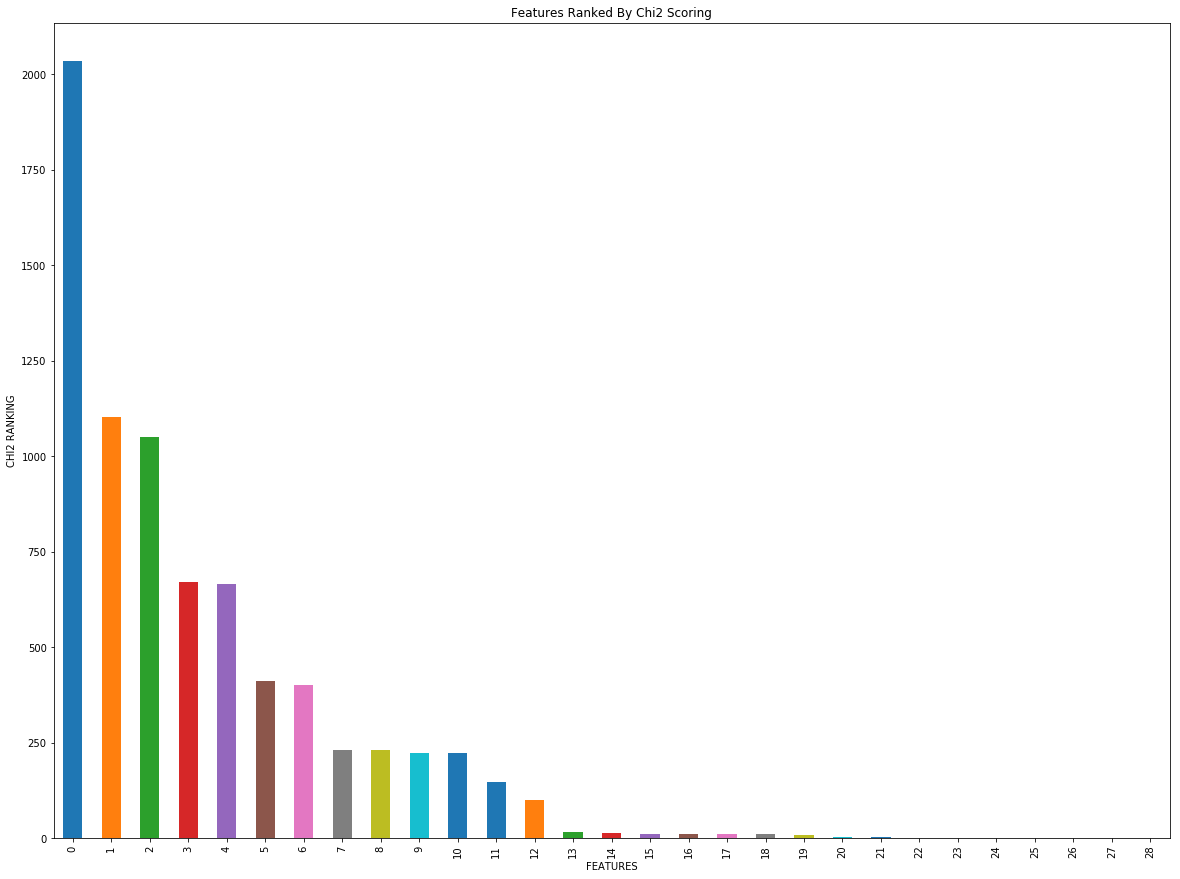



Table [REP_HIST_SYSMETRIC_SUMMARY]
Original number of features: 140
Reduced number of features: 30

Feature [TOTAL PGA ALLOCATED] with score [1536.0598394994063]
Feature [CELL PHYSICAL IO INTERCONNECT BYTES] with score [971.007954616221]
Feature [TOTAL PGA USED BY SQL WORKAREAS] with score [805.9516546154506]
Feature [PHYSICAL READ BYTES PER SEC] with score [64.84773919349183]
Feature [PHYSICAL READ TOTAL BYTES PER SEC] with score [64.1201063090792]
Feature [TEMP SPACE USED] with score [42.75603829651253]
Feature [VM IN BYTES PER SEC] with score [31.72922548131208]
Feature [PHYSICAL WRITE BYTES PER SEC] with score [10.678487946311318]
Feature [PHYSICAL WRITE TOTAL BYTES PER SEC] with score [10.0962860465259]
Feature [CONSISTENT READ GETS PER TXN] with score [1.7058252011802983]
Feature [LOGICAL READS PER TXN] with score [1.704648623503413]
Feature [REDO GENERATED PER SEC] with score [0.6503466293380139]
Feature [REDO GENERATED PER TXN] with score [0.4338460619401169]
Feature [CONSIST

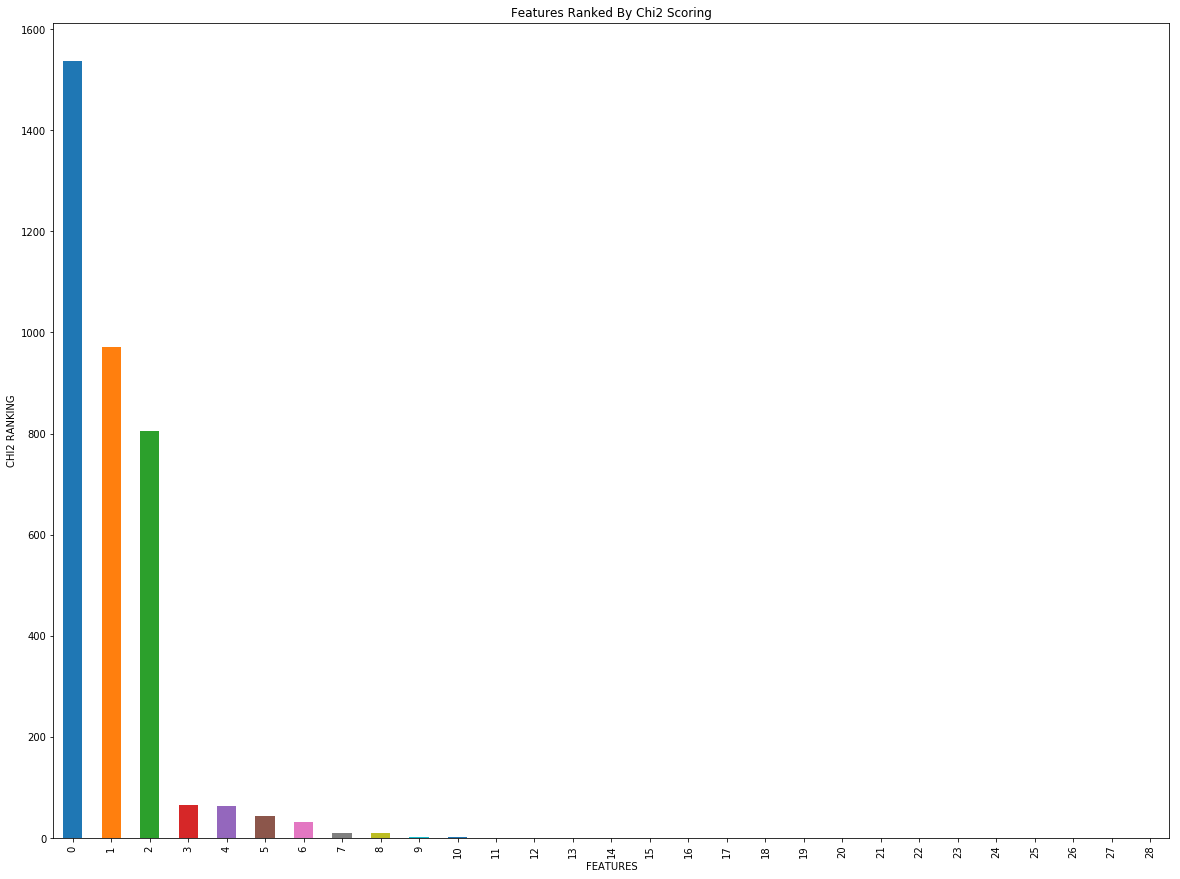



Table [REP_HIST_SYSSTAT]
Original number of features: 321
Reduced number of features: 30

Feature [PHYSICAL READ BYTES] with score [94.93551877765576]
Feature [PHYSICAL READ TOTAL BYTES] with score [93.90896699983921]
Feature [CELL PHYSICAL IO INTERCONNECT BYTES] with score [56.19645211006452]
Feature [PHYSICAL WRITE TOTAL BYTES] with score [27.8939987555101]
Feature [PHYSICAL WRITE BYTES] with score [22.877678955366257]
Feature [FILE IO WAIT TIME] with score [11.659375666516341]
Feature [REDO SIZE] with score [4.985163349202385]
Feature [KTFB ALLOC SPACE (BLOCK)] with score [3.777423736813437]
Feature [SESSION UGA MEMORY MAX] with score [3.0812858622184267]
Feature [IMU REDO ALLOCATION SIZE] with score [1.5258748982672383]
Feature [UNDO CHANGE VECTOR SIZE] with score [1.4332375857895272]
Feature [REDO SYNCH TIME OVERHEAD (USEC)] with score [1.2621002638122805]
Feature [BYTES RECEIVED VIA SQL*NET FROM CLIENT] with score [1.2098029146117923]
Feature [TABLE SCAN DISK NON-IMC ROWS GOTTE

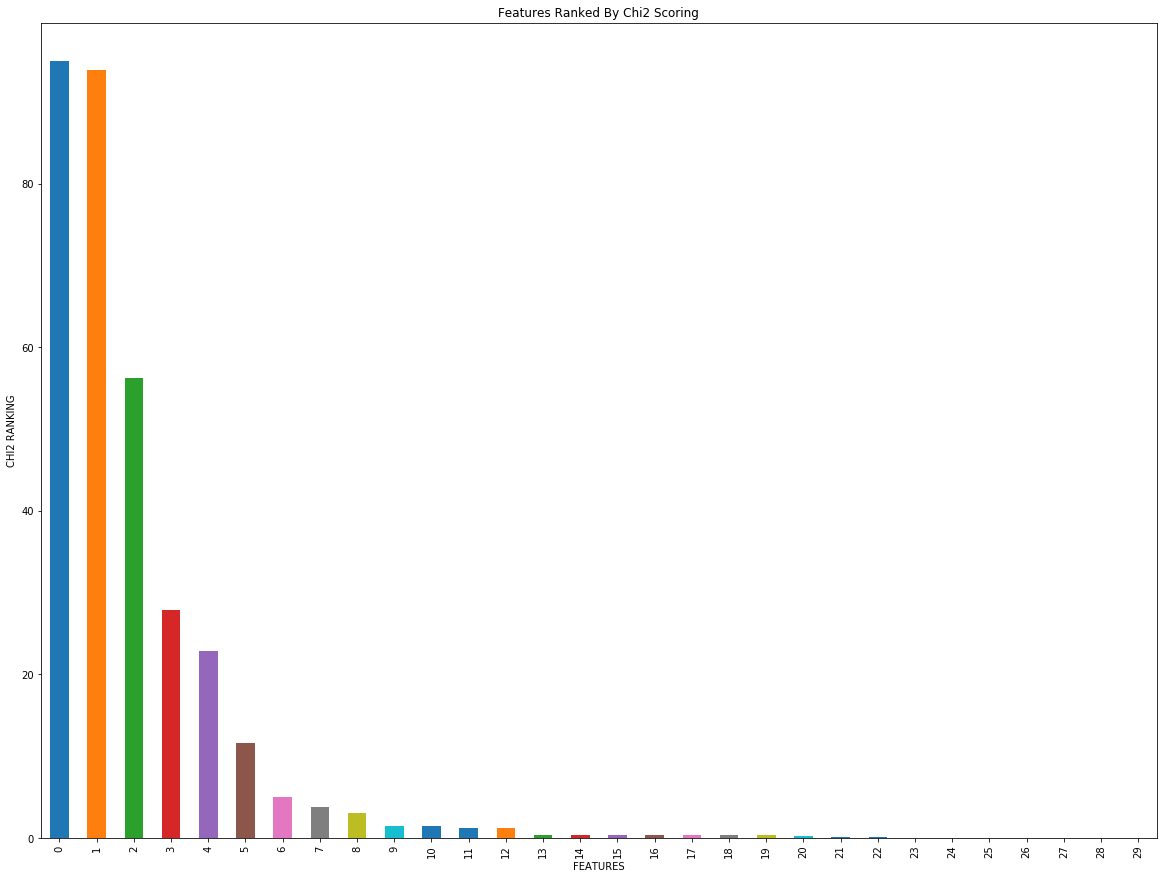

In [123]:
top_n_features=30
def chi2_test(top_n_features=30, X_df=None, y_df=None, table=None, headers=None):
    """
    Carries out a chi squared test on passed X,y dataframes, selecting top N features ranked by highest scoring
    """
    chi2_selector = SelectKBest(score_func=chi2, k=top_n_features)
    X_kbest = chi2_selector.fit_transform(X_df, y_df)
    print('\n\nTable [' + table.upper() + ']')
    print('Original number of features: ' + str(X_df.shape[1]))
    print('Reduced number of features: ' + str(X_kbest.shape[1]) + "\n")
    outcome = chi2_selector.get_support()
    #
    scoring_sheet = []
    for i in range(0,len(headers)-1):
        if outcome[i]:
            scoring_sheet.append([headers[i],chi2_selector.scores_[i]])
    #
    scoring_sheet = sorted(scoring_sheet, key=itemgetter(1), reverse=True)
    [print('Feature [' + str(row) + '] with score [' + str(score) + ']') for row, score in scoring_sheet[:top_n_features]]
    #
    scoring_sheet = pd.Series((v[1] for v in scoring_sheet[:top_n_features]) )
    scoring_sheet[:top_n_features].plot.bar()
    plt.ylabel('CHI2 RANKING')
    plt.xlabel('FEATURES')
    plt.title('Features Ranked By Chi2 Scoring')
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.show()
#
chi2_test(top_n_features=top_n_features, X_df=rep_hist_snapshot_df_pruned_norm, y_df=rep_hist_snapshot_df_pruned['SNAP_ID'], table='REP_HIST_SNAPSHOT', headers=retain_headers_rep_hist_snapshot)
chi2_test(top_n_features=top_n_features, X_df=rep_hist_sysmetric_summary_df_pruned_norm, y_df=rep_hist_sysmetric_summary_df_pruned['SNAP_ID'], table='REP_HIST_SYSMETRIC_SUMMARY', headers=retain_headers_rep_hist_sysmetric_summary)
chi2_test(top_n_features=top_n_features, X_df=rep_hist_sysstat_df_pruned_norm, y_df=rep_hist_sysstat_df_pruned['SNAP_ID'], table='REP_HIST_SYSSTAT', headers=retain_headers_rep_hist_sysstat)

### Random Forest Feature Importance

Calculating MI (Mutual Information) scoring between data matrix X (feature vectors) and target column y ('SNAP_ID') 

                               importance
feature                                  
DISK_READS_TOTAL                    0.560
PHYSICAL_READ_BYTES_TOTAL           0.115
CCWAIT_TOTAL                        0.073
PHYSICAL_WRITE_BYTES_TOTAL          0.032
IO_INTERCONNECT_BYTES_DELTA         0.021
BUFFER_GETS_TOTAL                   0.021
IO_OFFLOAD_RETURN_BYTES_TOTAL       0.018
CPU_TIME_DELTA                      0.017
PHYSICAL_READ_REQUESTS_TOTAL        0.016
IOWAIT_TOTAL                        0.014
OPTIMIZER_COST                      0.014
ELAPSED_TIME_DELTA                  0.013
SORTS_TOTAL                         0.010
BUFFER_GETS_DELTA                   0.010
SHARABLE_MEM                        0.008
PHYSICAL_WRITE_BYTES_DELTA          0.007
CPU_TIME_TOTAL                      0.006
PLSEXEC_TIME_TOTAL                  0.006
FETCHES_TOTAL                       0.006
EXECUTIONS_TOTAL                    0.005
ROWS_PROCESSED_TOTAL                0.004
PHYSICAL_WRITE_REQUESTS_TOTAL     

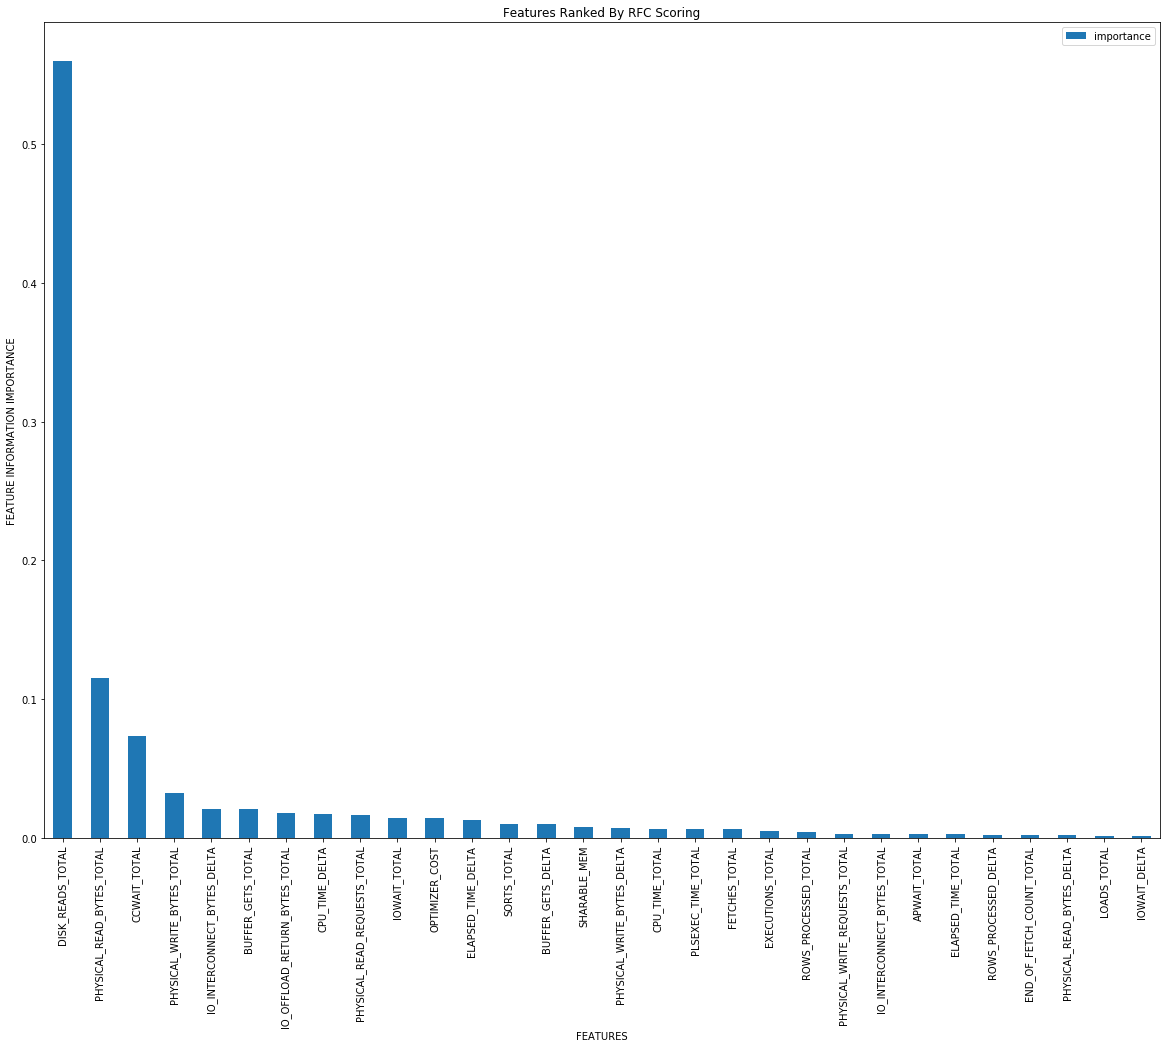

                                         importance
feature                                            
LOGICAL READS PER TXN                         0.215
SNAP_ID                                       0.156
REDO GENERATED PER SEC                        0.100
TOTAL PGA USED BY SQL WORKAREAS               0.099
LOGICAL READS PER SEC                         0.078
CONSISTENT READ GETS PER TXN                  0.043
PHYSICAL READ BYTES PER SEC                   0.042
NETWORK TRAFFIC VOLUME PER SEC                0.040
CONSISTENT READ GETS PER SEC                  0.038
PHYSICAL READ TOTAL BYTES PER SEC             0.037
TEMP SPACE USED                               0.036
PHYSICAL WRITE BYTES PER SEC                  0.022
REDO GENERATED PER TXN                        0.018
PHYSICAL WRITE TOTAL BYTES PER SEC            0.010
TOTAL PGA ALLOCATED                           0.010
CELL PHYSICAL IO INTERCONNECT BYTES           0.008
RECURSIVE CALLS PER TXN                       0.007
RECURSIVE CA

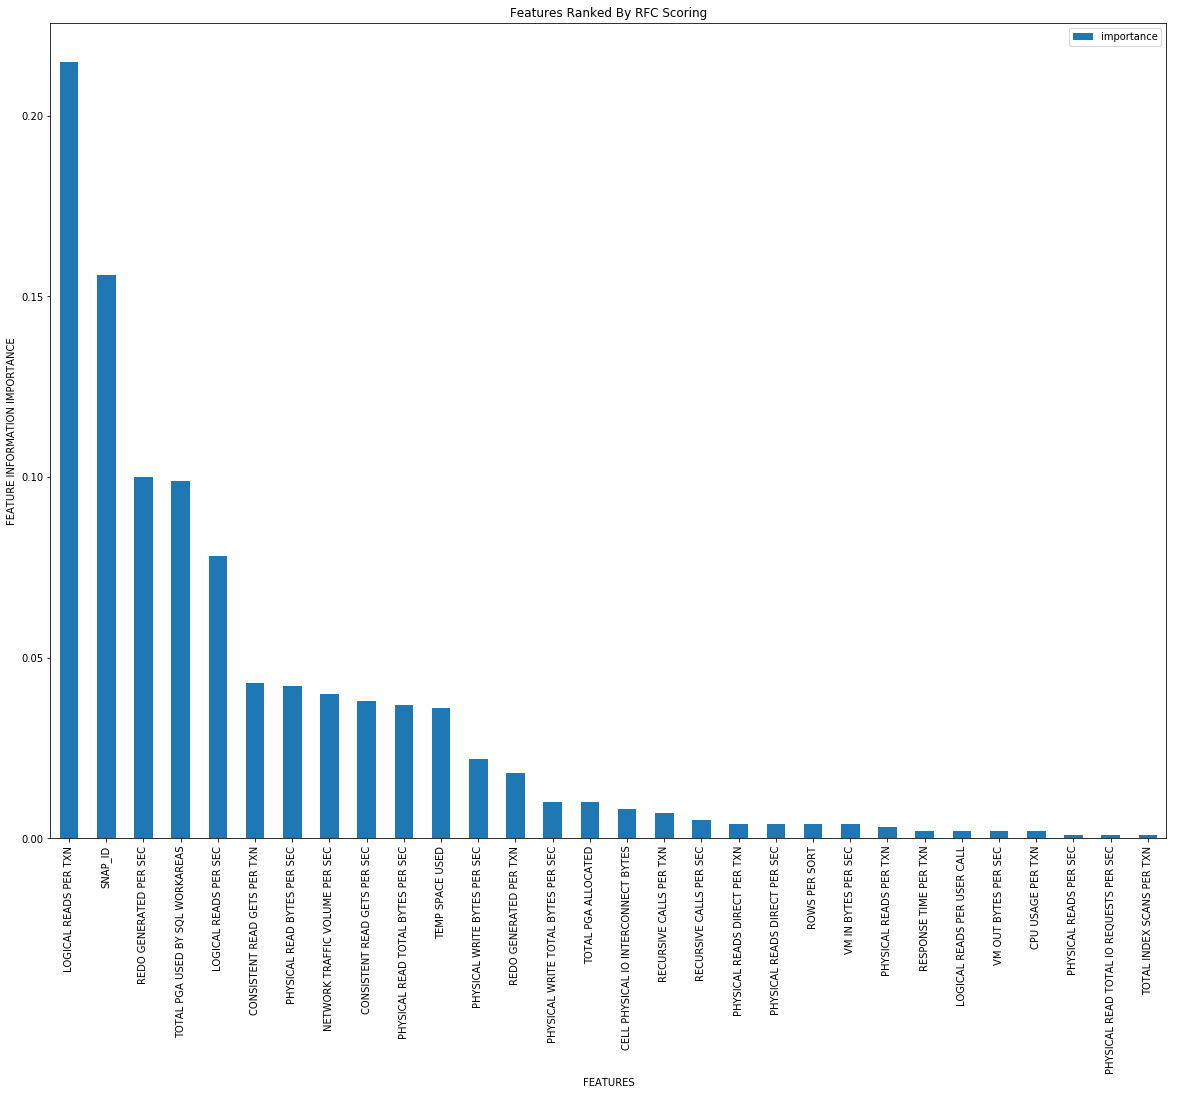

                                        importance
feature                                           
PHYSICAL WRITE BYTES                         0.121
FILE IO WAIT TIME                            0.100
PHYSICAL WRITE TOTAL BYTES                   0.100
SESSION UGA MEMORY MAX                       0.090
REDO SIZE                                    0.066
TABLE SCAN DISK NON-IMC ROWS GOTTEN          0.057
KTFB ALLOC SPACE (BLOCK)                     0.047
IMU REDO ALLOCATION SIZE                     0.047
TABLE SCAN ROWS GOTTEN                       0.046
REDO SYNCH TIME OVERHEAD (USEC)              0.044
BYTES RECEIVED VIA SQL*NET FROM CLIENT       0.043
UNDO CHANGE VECTOR SIZE                      0.038
BUFFER IS PINNED COUNT                       0.030
REDO SYNCH TIME (USEC)                       0.023
REDO WRITE FINISH TIME                       0.021
REDO WRITE TIME (USEC)                       0.020
REDO WRITE TOTAL TIME                        0.020
IMU UNDO ALLOCATION SIZE       

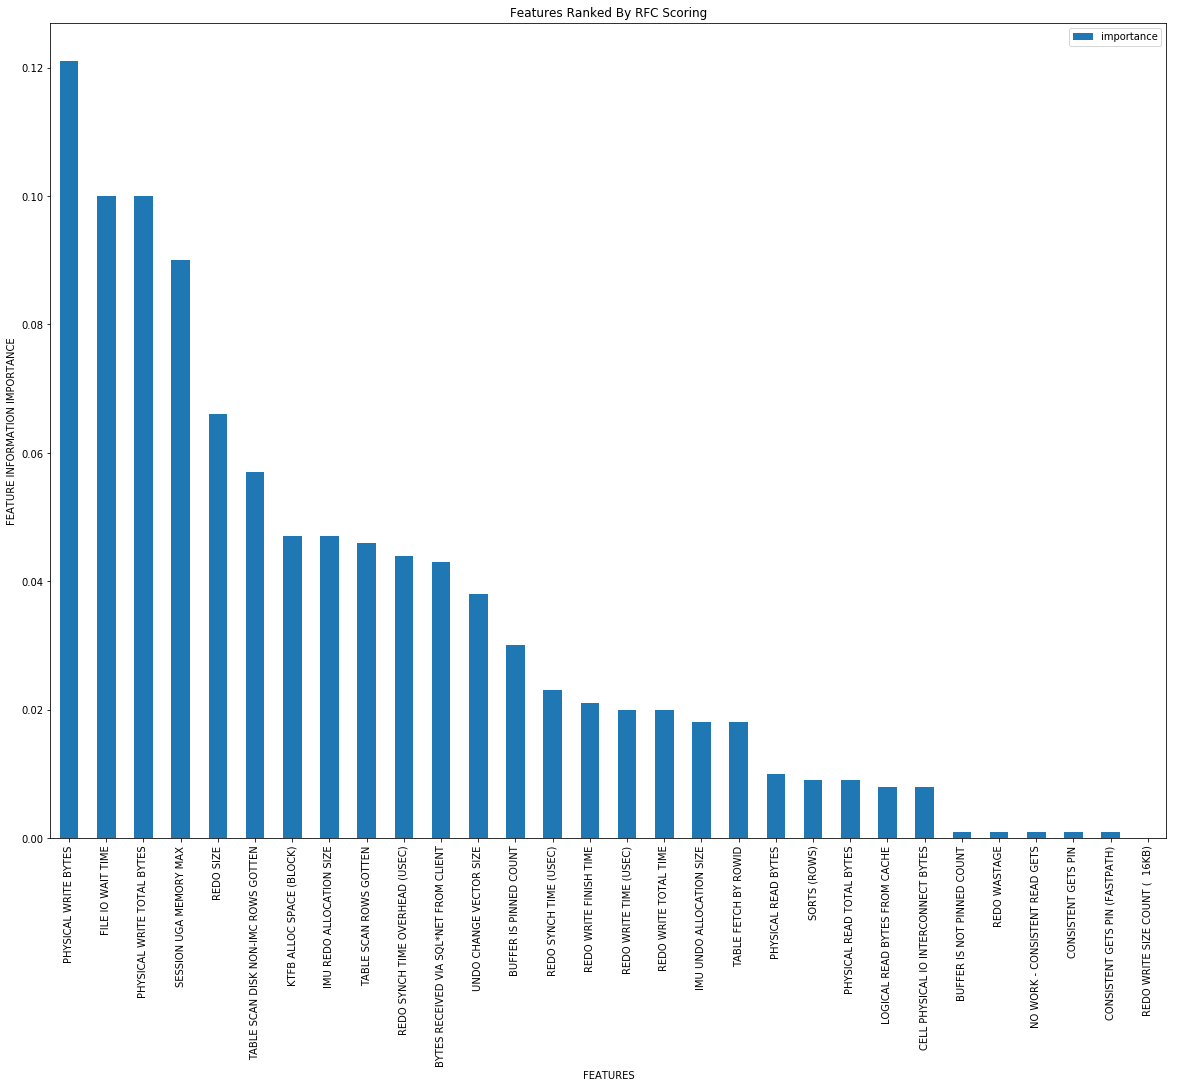

In [125]:
def rfr_ranking(X_df=None, y_df=None, headers=None, top_n_features=30):
    """
    Ranks features using a filter RFR method, and plots them in descending order (ranked by importance)
    """
    X_df = np.array(X_df)
    y_df = np.array(y_df)
    rfr = RandomForestRegressor(n_estimators=2000)
    rfr.fit(X_df, y_df)
    importances = pd.DataFrame({'feature':headers,
                                'importance':np.round(rfr.feature_importances_,3)})
    importances = importances.sort_values('importance',ascending=False).set_index('feature')
    print(importances[:top_n_features])
    importances[:top_n_features].plot.bar()
    plt.ylabel('FEATURE INFORMATION IMPORTANCE')
    plt.xlabel('FEATURES')
    plt.title('Features Ranked By RFC Scoring')
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.show()
#
rfr_ranking(top_n_features=top_n_features,
            X_df=rep_hist_snapshot_df_pruned_norm, 
            y_df=rep_hist_snapshot_df_pruned['SNAP_ID'], 
            headers=retain_headers_rep_hist_snapshot)
rfr_ranking(top_n_features=top_n_features,
            X_df=rep_hist_sysmetric_summary_df_pruned_norm, 
            y_df=rep_hist_sysmetric_summary_df_pruned['SNAP_ID'], 
            headers=retain_headers_rep_hist_sysmetric_summary)
rfr_ranking(top_n_features=top_n_features,
            X_df=rep_hist_sysstat_df_pruned_norm, 
            y_df=rep_hist_sysstat_df_pruned['SNAP_ID'], 
            headers=retain_headers_rep_hist_sysstat)

### Wrapper Methods

Use a number of machine learning models to evaluate features individually and rank by highest. The following machine learning models will be opted for:

* Random Forest Classifier
* Gradient Boosting

In a 'Brute-Fore' approach, these machine learning heuristics will strip away 1 feature at a time in a method referred to as 'Recursive Feature Elimination', and compare accuracy with every variable elimination. This allows the respective classifier to establish an optimum feature configuration with the highest accuracy score.

https://www.fabienplisson.com/choosing-right-features/

### Random Forest Wrapper (Feature Combination)

In [126]:
def rfr_wrapper(X_df=None, y_df=None, test_split=.4, random_state=42, table_name=None):
    """
    Random Forest Regressor - Takes data matrix and target vector, and evaluates best combination of features 
    using an RFR model.
    """
    X_df = np.array(X_df)
    y_df = np.array(y_df)
    #feature_count = len(X_df[0])
    feature_count=100
    val_op, optimum_features = 0, 0
    val_op = 0
    X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=test_split)
    model = RandomForestRegressor(n_estimators=feature_count)
    model.fit(X_train, y_train)
    #
    # make predictions for test data and evaluate
    pred_y = model.predict(X_test)
    predictions = [round(value) for value in pred_y]
    r2s = r2_score(y_test, predictions)
    print("Table [" + table_name + "] RFR R2 Score: " + str(r2s))
    # 
    # fit model using each importance as a threshold
    #print(type(model.feature_importances_))
    thresholds = np.sort(model.feature_importances_)[:feature_count]
    for thresh in thresholds:
        # selecting features using threshold
        selection = SelectFromModel(model, threshold=thresh, prefit=True)
        select_train_x = selection.transform(X_train)
        #
        # training model
        selection_model = RandomForestRegressor(n_estimators=feature_count)
        selection_model.fit(select_train_x, y_train)
        #
        # evaluating model
        select_test_x = selection.transform(X_test)
        pred_y = selection_model.predict(select_test_x)
        predictions = [round(value) for value in pred_y]
        r2s = r2_score(y_test, predictions)
        print("Thresh=" + str(thresh) + ", n=" + str(select_train_x.shape[1]) + ", R2 Score: " + str(r2s))
        if(r2s > val_op):
            val_op = r2s
            optimum_features = select_train_x.shape[1]
    print("\n\n------------------------------------------\n\n")
    return val_op, optimum_features
#
rfr_rep_hist_snapshot_score, rfr_rep_hist_snapshot_count = rfr_wrapper(X_df=rep_hist_snapshot_df_pruned_norm,
                                                                        y_df=rep_hist_snapshot_df_pruned['SNAP_ID'],
                                                                        test_split=test_split,
                                                                        table_name='REP_HIST_SNAPSHOT')
rfr_hist_sysmetric_summary_score, rfr_hist_sysmetric_summary_count = rfr_wrapper(X_df=rep_hist_sysmetric_summary_df_pruned_norm,
                                                                                 y_df=rep_hist_sysmetric_summary_df_pruned['SNAP_ID'],
                                                                                 test_split=test_split,
                                                                                 table_name='REP_HIST_SYSMETRIC_SUMMARY')
rfr_hist_sysstat_score, rfr_hist_sysstat_count = rfr_wrapper(X_df=rep_hist_sysstat_df_pruned_norm,
                                                               y_df=rep_hist_sysstat_df_pruned['SNAP_ID'],
                                                               test_split=test_split,
                                                               table_name='REP_HIST_SYSSTAT')

Table [REP_HIST_SNAPSHOT] RFR R2 Score: 0.9814284008112646


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=51, R2 Score: 0.9810100763877017


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=51, R2 Score: 0.9811920767975656


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=51, R2 Score: 0.9805737074273425


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=2.662514377645946e-07, n=48, R2 Score: 0.9811210839916581


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=9.862764245660793e-07, n=47, R2 Score: 0.9811994290598757


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=3.4862667519361096e-06, n=46, R2 Score: 0.9815767245802434


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=8.380057489157284e-06, n=45, R2 Score: 0.9816486262083046


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=8.988868568527563e-06, n=44, R2 Score: 0.9806086529098096


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=1.9030828834761717e-05, n=43, R2 Score: 0.981152352435358


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=2.716122455803302e-05, n=42, R2 Score: 0.9819726473243143


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=3.539582388406789e-05, n=41, R2 Score: 0.9812383577488926


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=4.393554955568332e-05, n=40, R2 Score: 0.9801574711164645


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=4.647058757468716e-05, n=39, R2 Score: 0.9822863821709411


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=7.136597726174175e-05, n=38, R2 Score: 0.9811548471582208


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0005530306465337167, n=37, R2 Score: 0.9808282218008332


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0007455955624731079, n=36, R2 Score: 0.981714209646666


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0010617309315061288, n=35, R2 Score: 0.9814721785686835


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0010701950972074313, n=34, R2 Score: 0.9814617991178015


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0010802375112804125, n=33, R2 Score: 0.9811927720283609


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0010935631814048383, n=32, R2 Score: 0.9817035452056146


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0011062201509682713, n=31, R2 Score: 0.9813192895113226


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.001309195261303278, n=30, R2 Score: 0.9817370191464853


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0014055603812604968, n=29, R2 Score: 0.9819408712229665


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0014426445176411121, n=28, R2 Score: 0.980979711925558


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0016360193790240733, n=27, R2 Score: 0.9816827584704158


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.002024948983977605, n=26, R2 Score: 0.9816686408682251


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0022048325092407202, n=25, R2 Score: 0.9814793680659075


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.002999954632741723, n=24, R2 Score: 0.9811629442674491


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.003209523701573474, n=23, R2 Score: 0.9821399220319444


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.003907877014670301, n=22, R2 Score: 0.9802744199486014


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.004310548901161228, n=21, R2 Score: 0.9811007401711174


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.005381522897271114, n=20, R2 Score: 0.9815369651237051


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.005723668261957655, n=19, R2 Score: 0.9811491521954306


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.00578066634610048, n=18, R2 Score: 0.979542603918429


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.009189696641827897, n=17, R2 Score: 0.9803228834042617


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.009679175213993167, n=16, R2 Score: 0.9795783009036357


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.011531439998126366, n=15, R2 Score: 0.9805027152265097


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.011884985638544374, n=14, R2 Score: 0.9776730847443545


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.012384728652273701, n=13, R2 Score: 0.9771196314151324


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.01340176459028727, n=12, R2 Score: 0.9778291843279122


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.014642545005781788, n=11, R2 Score: 0.9755163051607463


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.015908556318583383, n=10, R2 Score: 0.975122102643961


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.018552784604973754, n=9, R2 Score: 0.9770698718895299


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.020817638944150552, n=8, R2 Score: 0.9701806508362969


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.02280806881434438, n=7, R2 Score: 0.9664873603686911


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.024225628607920432, n=6, R2 Score: 0.9659246524223978


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.029965963925025537, n=5, R2 Score: 0.9549739922949713


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.03366166969577767, n=4, R2 Score: 0.9502826850115341


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.05616374013566766, n=3, R2 Score: 0.9217969409921305


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.08324736105661967, n=2, R2 Score: 0.83355146374394


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.5636212485744643, n=1, R2 Score: 0.6835432177112233


------------------------------------------


Table [REP_HIST_SYSMETRIC_SUMMARY] RFR R2 Score: 0.8873312309340674


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.880293332114079


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8851156834720922


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8838256764274572


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8853245895548


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8846026549061103


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8837756888754796


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8852107784771638


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8846578276020605


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.886287415820135


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8871812832191187


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.887119365291455


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8857792642403318


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8843463971100106


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8823447584702034


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8839000034648347


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8864331234083462


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8844698152403284


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8838718558961498


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8847578157793765


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8856286242597933


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8845716685504746


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8846150864273


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.885341628501916


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8839667193159702


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8872831956706597


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8858821559488627


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8847639011176323


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8850185322141042


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8872351093588902


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8849755034254025


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8855455200168847


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8830468932024508


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8847701489390885


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8832800298258838


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8833987689380605


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8863013227634899


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8852080193754606


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8818161109731221


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.887034177403826


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8844289329729881


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8817773490804209


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8868815042043879


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8867091033032635


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8858844319587514


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8834443775366578


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8835832558501207


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8846211954221136


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8841512386001623


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8869397485176224


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8823840520129168


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8852393481286452


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8839821054167364


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8843864445498727


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.883113373110548


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8848574117558639


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8852223427987431


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8849351727293864


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8881181271133601


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.8831229895013446


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=140, R2 Score: 0.884129859297208


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=7.0935659024307e-11, n=80, R2 Score: 0.8854654002355207


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=1.1932930883122346e-09, n=79, R2 Score: 0.8836949316121336


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=1.0656978341295927e-07, n=78, R2 Score: 0.8878380807806439


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=1.314375777987843e-07, n=77, R2 Score: 0.8857405577537795


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=1.8490741675235343e-07, n=76, R2 Score: 0.8862972943006917


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=2.970250161357338e-07, n=75, R2 Score: 0.8826826581604074


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=3.2055389974868687e-07, n=74, R2 Score: 0.8844180285448666


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=6.122757632691301e-07, n=73, R2 Score: 0.8838659847119975


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=7.550222948497117e-07, n=72, R2 Score: 0.8821667883173105


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=1.2705702832318514e-06, n=71, R2 Score: 0.8843533876228775


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=1.3304178734733442e-06, n=70, R2 Score: 0.8874571821837062


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=1.4211855304925112e-06, n=69, R2 Score: 0.8876104411942234


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=1.9665248950116437e-06, n=68, R2 Score: 0.8855416092143351


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=3.498748964430554e-06, n=67, R2 Score: 0.8842168575340593


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=3.933420020246217e-06, n=66, R2 Score: 0.8844931642630005


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=4.515620128854161e-06, n=65, R2 Score: 0.8854478290158514


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=5.012094129232943e-06, n=64, R2 Score: 0.8821702477776365


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=1.465927250899566e-05, n=63, R2 Score: 0.8869336382777266


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=1.4856327801148933e-05, n=62, R2 Score: 0.8864198844514821


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=1.5022074908128645e-05, n=61, R2 Score: 0.884321381545087


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=1.743251965626706e-05, n=60, R2 Score: 0.8848307813195913


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=1.933362144458094e-05, n=59, R2 Score: 0.8827222125477989


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=1.9983188854775705e-05, n=58, R2 Score: 0.8840112328649521


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=2.019138589344512e-05, n=57, R2 Score: 0.8864071360569246


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=2.2167763139559114e-05, n=56, R2 Score: 0.8858510382370763


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=2.9801730313833542e-05, n=55, R2 Score: 0.8820888474294396


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=3.296811339842347e-05, n=54, R2 Score: 0.8898104699541998


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=3.838971648330607e-05, n=53, R2 Score: 0.8875982244496781


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=4.140695618587084e-05, n=52, R2 Score: 0.8843065544861369


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=4.649942112897841e-05, n=51, R2 Score: 0.8864906810588598


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=4.869594240796503e-05, n=50, R2 Score: 0.8851802820612934


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=5.686270599562352e-05, n=49, R2 Score: 0.883928911156078


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=5.707080793560219e-05, n=48, R2 Score: 0.8839183273365705


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=5.9821110895709894e-05, n=47, R2 Score: 0.8845966062977736


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=6.157466681279631e-05, n=46, R2 Score: 0.8843455797136802


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=7.083554285942582e-05, n=45, R2 Score: 0.884449478693546


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=8.926549724186038e-05, n=44, R2 Score: 0.8868310572171538


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.00016101978869569785, n=43, R2 Score: 0.8843430721185402


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.00016417152555047983, n=42, R2 Score: 0.8830381465014285


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.00017446653850675134, n=41, R2 Score: 0.8858149439325517


------------------------------------------


Table [REP_HIST_SYSSTAT] RFR R2 Score: 0.9999948426718025


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999961111566323


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999963235852339


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999962560219824


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999960058553485


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999960661144647


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999956102146866


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999962359356104


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.999995595606416


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999918528457543


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.999995980290875


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999960168115515


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999949662334245


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999960588103294


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999960642884309


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999961507206986


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999947732825172


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.999996115417378


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.999996094722328


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999948420631245


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.999994826237498


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999962243707294


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999960588103294


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999943186000949


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999948816271907


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.999991824237891


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999960667231427


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999962444571016


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999960502888382


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999961312430045


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999960362892456


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999935985340902


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999960928962941


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999962195013059


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999961969802221


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999961549814441


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999961817632735


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999949297127481


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999962103711368


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999950246665069


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999959681173162


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999961592421898


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999943478166361


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999961835893074


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999961196781235


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999961336777162


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999959145536573


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999961805459177


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999960594190074


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999961866326971


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999961628942574


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999961695897147


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999961002004294


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999963114116751


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999959431615205


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.99999125390666


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999961032438192


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999960180289074


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999955883022807


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999947799779745


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999960265503985


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999960022032809


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.999996083766125


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999960241156868


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999962280227971


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999955237824188


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999960551582617


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999962048930353


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.999996167155003


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999961081132427


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999961300256486


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999960271590764


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999963065422516


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999961744591382


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.999996188458731


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999960594190074


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999960661144647


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999961635029353


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999960155941956


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999961056785309


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999948737143775


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999961300256486


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999961239388692


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.999996280977778


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999960995917515


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999961695897147


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999953247447321


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999948651928863


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999959942904676


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999937293998477


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999962079364251


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999928942937121


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.999996062462397


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999936782709006


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999929935082165


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999949449296966


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999959541177235


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999962785430663


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999962414137118


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=321, R2 Score: 0.9999945803316097
Thresh=0.0, n=321, R2 Score: 0.9999960575929735


------------------------------------------




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


### Gradient Boosting Wrapper (Feature Combination)

https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/

In [127]:
def gradient_boosting_wrapper(X_df=None, y_df=None, test_split=.4, random_state=42, table_name=None):
    """
    Gradient Boosting Regressor - Takes data matrix and target vector, and evaluates best combination of features 
    using a GBR model.
    """
    X_df = np.array(X_df)
    y_df = np.array(y_df)
    #feature_count = len(X_df[0])
    feature_count=100
    val_op, optimum_features = 0, 0
    X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=test_split)
    model = GradientBoostingRegressor(n_estimators=feature_count)
    model.fit(X_train, y_train)
    #
    # make predictions for test data and evaluate
    pred_y = model.predict(X_test)
    predictions = [round(value) for value in pred_y]
    r2s = r2_score(y_test, predictions)
    print("Table [" + table_name + "] RFR R2 Score: " + str(r2s))
    # 
    # fit model using each importance as a threshold
    #print(type(model.feature_importances_))
    thresholds = np.sort(model.feature_importances_)[:feature_count]
    for thresh in thresholds:
        # selecting features using threshold
        selection = SelectFromModel(model, threshold=thresh, prefit=True)
        select_train_x = selection.transform(X_train)
        #
        # training model
        selection_model = GradientBoostingRegressor(n_estimators=feature_count)
        selection_model.fit(select_train_x, y_train)
        #
        # evaluating model
        select_test_x = selection.transform(X_test)
        pred_y = selection_model.predict(select_test_x)
        predictions = [round(value) for value in pred_y]
        r2s = r2_score(y_test, predictions)
        print("Thresh=" + str(thresh) + ", n=" + str(select_train_x.shape[1]) + ", R2 Score: " + str(r2s))
        if(r2s > val_op):
            val_op = r2s
            optimum_features = select_train_x.shape[1]
    print("\n\n------------------------------------------\n\n")
    return val_op, optimum_features
#
gbw_rep_hist_snapshot_score, gbw_rep_hist_snapshot_count = gradient_boosting_wrapper(X_df=rep_hist_snapshot_df_pruned_norm,
                                                                                      y_df=rep_hist_snapshot_df_pruned['SNAP_ID'],
                                                                                      test_split=test_split,
                                                                                      table_name='REP_HIST_SNAPSHOT')
gbw_hist_sysmetric_summary_score, gbw_hist_sysmetric_summary_count = gradient_boosting_wrapper(X_df=rep_hist_sysmetric_summary_df_pruned_norm,
                                                                                              y_df=rep_hist_sysmetric_summary_df_pruned['SNAP_ID'],
                                                                                              test_split=test_split,
                                                                                              table_name='REP_HIST_SYSMETRIC_SUMMARY')
gbw_hist_sysstat_score, gbw_hist_sysstat_count = gradient_boosting_wrapper(X_df=rep_hist_sysstat_df_pruned_norm,
                                                                          y_df=rep_hist_sysstat_df_pruned['SNAP_ID'],
                                                                          test_split=test_split,
                                                                          table_name='REP_HIST_SYSSTAT')

Table [REP_HIST_SNAPSHOT] RFR R2 Score: 0.9648548056795971


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Thresh=0.0, n=51, R2 Score: 0.9648311063917079
Thresh=0.0, n=51, R2 Score: 0.9646483810873635
Thresh=0.0, n=51, R2 Score: 0.9647802354314698
Thresh=0.0, n=51, R2 Score: 0.9647700499360066
Thresh=0.0, n=51, R2 Score: 0.9646137833193286
Thresh=0.0, n=51, R2 Score: 0.9648558968939587
Thresh=0.0, n=51, R2 Score: 0.9647190348882718
Thresh=0.0, n=51, R2 Score: 0.964683245914121
Thresh=0.0, n=51, R2 Score: 0.9647941013687695
Thresh=0.0, n=51, R2 Score: 0.964580551898246
Thresh=0.0, n=51, R2 Score: 0.9649123574553655
Thresh=0.0, n=51, R2 Score: 0.9646308719722354
Thresh=0.0, n=51, R2 Score: 0.9647696785380623
Thresh=0.0, n=51, R2 Score: 0.9647103517533894
Thresh=0.0, n=51, R2 Score: 0.9647520663258459
Thresh=0.0, n=51, R2 Score: 0.9646330575062925
Thresh=2.0749914606659363e-05, n=35, R2 Score: 0.9647460606099234
Thresh=0.00018429886592413958, n=34, R2 Score: 0.9647541642894847
Thresh=0.00030640901144326273, n=33, R2 Score: 0.9631273406804877
Thresh=0.00048445442337007386, n=32, R2 Score: 0.962

Thresh=0.0, n=321, R2 Score: 0.9999380505201637
Thresh=0.0, n=321, R2 Score: 0.9999373971758488
Thresh=0.0, n=321, R2 Score: 0.9999385776292433
Thresh=0.0, n=321, R2 Score: 0.9999378017443831
Thresh=0.0, n=321, R2 Score: 0.9999381786027438
Thresh=0.0, n=321, R2 Score: 0.9999377801920258
Thresh=0.0, n=321, R2 Score: 0.999937496316692
Thresh=0.0, n=321, R2 Score: 0.9999376083889497
Thresh=0.0, n=321, R2 Score: 0.999937496316692
Thresh=0.0, n=321, R2 Score: 0.9999381909183765
Thresh=0.0, n=321, R2 Score: 0.9999382020024459
Thresh=0.0, n=321, R2 Score: 0.999938436615249
Thresh=0.0, n=321, R2 Score: 0.9999379187428937
Thresh=0.0, n=321, R2 Score: 0.9999383079168872
Thresh=0.0, n=321, R2 Score: 0.9999377235401155
Thresh=0.0, n=321, R2 Score: 0.999938382426465
Thresh=0.0, n=321, R2 Score: 0.9999372758668668
Thresh=0.0, n=321, R2 Score: 0.9999377937392219
Thresh=0.0, n=321, R2 Score: 0.9999381939972847
Thresh=0.0, n=321, R2 Score: 0.9999387241852725
Thresh=0.0, n=321, R2 Score: 0.9999370578801

### Recursive Feature Elimination

In [128]:
if rfr_rep_hist_snapshot_score > gbw_rep_hist_snapshot_score:
    rep_hist_snapshot_op = rfr_rep_hist_snapshot_count
    rep_hist_snapshot_model = 0
else:
    rep_hist_snapshot_op = gbw_rep_hist_snapshot_count
    rep_hist_snapshot_model = 1
#
if rfr_hist_sysmetric_summary_score > gbw_hist_sysmetric_summary_score:
    rep_hist_sysmetric_summary_op = rfr_hist_sysmetric_summary_count
    rep_hist_sysmetric_summary_model = 0
else:
    rep_hist_sysmetric_summary_op = gbw_hist_sysmetric_summary_count
    rep_hist_sysmetric_summary_model = 1
#
if rfr_hist_sysstat_score > gbw_hist_sysstat_score:
    rep_hist_sysstat_op = rfr_hist_sysstat_count
    rep_hist_sysstat_model = 0
else:
    rep_hist_sysstat_op = gbw_hist_sysstat_count
    rep_hist_sysstat_model = 1
#
def rfe_selector(X_df=None, y_df=None, test_split=.4, random_state=42, table_name=None, optimum_feature_count=0, model=None):
    """
    Recursive Feature Elimination Function
    """
    X_df = np.array(X_df)
    y_df = np.array(y_df)
    #feature_count = len(X_df[0])
    feature_count=100
    X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=test_split)
    if model == 0:
        model = RandomForestRegressor(n_estimators=feature_count)
    elif model == 1:
        model = GradientBoostingRegressor(n_estimators=feature_count)
    #
    # create the RFE model and select 4 attributes
    rfe_model = RFE(model, optimum_feature_count, step=1)
    rfe_model = rfe_model.fit(X_train, y_train)
    # 
    # summarize the selection of the attributes
    #     print(rfe_model.support_)
    #     print(rfe_model.ranking_)
    # 
    # evaluate the model on testing set
    pred_y = rfe_model.predict(X_test)
    predictions = [round(value) for value in pred_y]
    r2s = r2_score(y_test, predictions)
    print("Table [" + table_name + "] RFR R2 Score: " + str(r2s) + " with " + str(optimum_feature_count) + " features")
    print("\n\n------------------------------------------\n\n")
#
rfe_selector(X_df=rep_hist_snapshot_df_pruned_norm,
             y_df=rep_hist_snapshot_df_pruned['SNAP_ID'],
             test_split=test_split,
             table_name='REP_HIST_SNAPSHOT',
             optimum_feature_count=rep_hist_snapshot_op,
             model = rep_hist_snapshot_model)
rfe_selector(X_df=rep_hist_sysmetric_summary_df_pruned_norm,
             y_df=rep_hist_sysmetric_summary_df_pruned['SNAP_ID'],
             test_split=test_split,
             table_name='REP_HIST_SYSMETRIC_SUMMARY',
             optimum_feature_count=rep_hist_sysmetric_summary_op,
             model = rep_hist_sysmetric_summary_model)
rfe_selector(X_df=rep_hist_sysstat_df_pruned_norm,
             y_df=rep_hist_sysstat_df_pruned['SNAP_ID'],
             test_split=test_split,
             table_name='REP_HIST_SYSSTAT',
             optimum_feature_count=rep_hist_sysstat_op,
             model = rep_hist_sysstat_model)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Table [REP_HIST_SNAPSHOT] RFR R2 Score: 0.9842431893716362 with 39 features


------------------------------------------




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


Table [REP_HIST_SYSMETRIC_SUMMARY] RFR R2 Score: 0.885016798180603 with 54 features


------------------------------------------


Table [REP_HIST_SYSSTAT] RFR R2 Score: 0.9999957981749377 with 321 features


------------------------------------------




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
